# ASTR 596: FDS - The Midterm

### Dun, dun dun. 
#### (suspenseful music here)

## Start with the Cepheid data you have already seen in lecture 03 and 04.

## There are measurements of several Cepheid variable stars in each of 9 nearby galaxies.

## Begin by reading this code and familiarizing yourself with what attributes and functions are available to you. In particular, it will help to read comments at the top of the data file.

In [3]:
exec(open('cepheids.py').read())
ceph = Cepheids('../../data/03/R11ceph.dat')
hosts = ceph.list_hosts()

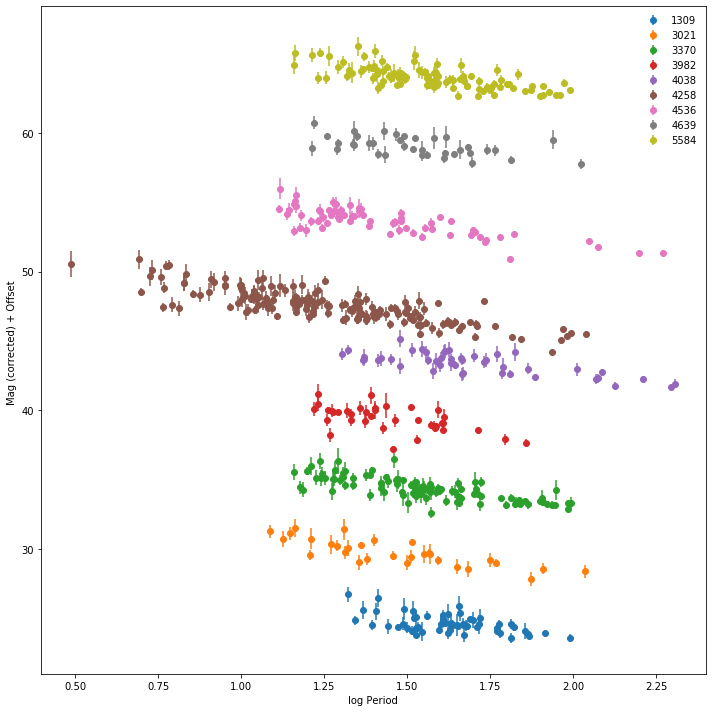

In [4]:
%matplotlib inline
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    ax.errorbar(logP, mobs+(5*i), yerr=sigma_obs, linestyle='None', marker='o', label=ID)
    
ax.legend(frameon=False)
ax.set_xlabel('log Period')
ax.set_ylabel('Mag (corrected) + Offset ')
fig.tight_layout()

# Q1.

## This data was taken from [Riess et al., 2011](https://arxiv.org/abs/1103.2976)

## The global model for the magnitudes of these Cepheids is given in Equation 1. You may ignore the effect of metalicity

## Some parameters (such as distance modulus) are specific to each galaxy.

## Others are common to all galaxies. 

## Assuming Gaussian magnitude errors and no period (and you may ignore metallicity entirely), but that Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{\text{int}}$, write down your expression for the likelihood being careful to use the same indices that Riess et. al used.


As stated in Reiss et al (2011), they express the $j$th Cepheid magnitude in the $i$th host as

$$m_{W,i,j} = (\mu_{0,i} - \mu_{0,4258}) + zp_{W,4258} + b_W \log P_{i,j} + Z_W \Delta \log [O/H]_{i,j}.$$

Here we ignore metallicity and assume no error in the period. However, we assume Gaussian magnitude errors scatter off the P-L relation via a Gaussian intrinsic dispersion $\sigma_{int}$. And so, our equation is now

$$model = m_{W,i,j} = (\mu_{0,i} - \mu_{0,4258}) + zp_{W,4258} + b_W \log P_{i,j}.$$

This is our model for the Cepheid P-L relation. In the form of a traditaional linear fit equation $"y=mx+b"$, our model $"y"$ is our magnitudes $m_{W,i,j}$; our slope $"m"$ is $b_W$; our $"x"$ is our $\log P_{i,j}$; our y-intercept $"b"$ is really our $zp_{W,4258}$. Additionally, this is in reference to NGC 4258, so we have an additional intercept term $(\mu_{0,i} - \mu_{0,4258})$ between the galaxy in question and NGC 4258. Succinctly,

$$ slope "m" = m_i = b_W $$
$$ y-intercept "b" = b_i = (\mu_{0,i} - \mu_{0,4258}) + zp_{W,4258}.$$

And so, given data points with known errors on y, assuming Gaussian error distribution we can solve for our parameters by maximizing the likelihood, which is equivalent to minimizing the $\chi^2$. This is as follows:

If our probability is

$$p(\hat{m}_{W,i,j}|m_{W,i,j}) = (2\pi \epsilon^2)^{-\frac{1}{2}} \exp{ \left(\frac{-(\hat{m}_{W,i,j} - m_{W,i,j})^2}{2 \epsilon^2} \right)}$$

where $m_{W,i,j}$ is the model value and $\hat{m}_{W,i,j}$ is the observed value, then our likelihood is

$$\mathcal{L} = \prod_i{p(\hat{m}_{W,i,j}|m_{W,i,j})}. $$

It is best to work with this likelihood in log space, and so our maximum likelihood solution is of the form

$$\ln \mathcal{L} = -\frac{1}{2} \sum{\exp{ \left(\frac{(\hat{m}_{W,i,j} - m_{W,i,j})^2}{\epsilon^2} +\ln (2 \pi \epsilon^2) \right)}} = \frac{- \chi^2}{2}. $$ 

where

$$\epsilon^2 = \sigma_{int}^2 + f^2 m_{W,i,j}^2 . $$

Here, Cepheids scatter off the period-luminosity relation because of some Gaussian intrinsic dispersion $\sigma_{int}$, and in case there is more error or this assumption is not good enough, we can assume that the variance is underestimated by some fractional amount $f$. If we want to look at the data fits without this fractional amount, we can simply ignore it, because this terms is additive in our error term, and thus our error would just be $\sigma_{int}$.

# Q2. 

## Given what you know for each of the parameters in this model, write down physically motivated (i.e. not just top hats on everything) priors, along with your explanation.

## Think particularly about the priors for distances to each galaxy.

Because we have a linear model fit, with model parameters for slope, y-intercept, and potential underestimated variance, we have some prior knowledge we can impose on them. Here we assume uniform priors for all model parameters.

For the slope $"m_i"$, we know it must be negative, as in the P-L relation, generally speaking the lower the period the fainter the object. Looking at the data, a reasonable range is $-5.0 < m_i < 0$. 

For the y-intercept $"b_i"$, we know it must be positive as no Cepheid has negative magnitudes like the moon or Sun, and from the data a reasonable range is $20.0 < b_i < 30.0$.

For any potential underestimate in the variance of the error, $"log f_i"$, we know it must be small, as if our assumption that all error is intrinsic Gaussian, then it should be 0. If not, then it should be close to zero for this assumption to be good. Hence, I chose $-7.0 < \log f_i < 0.0$.

# Q3. 

## Implement this likelihood and prior in python and sample the posterior distribution with emcee.

## Construct traceplots for each parameter, as well as corner plots for each pair of parameters.


## If your Markov Chains are reasonable, verify that your model fits are reasonable by reconstructing Fig. 7 of Riess et al. 2011

## Compare the intercept you find for the intercepts $\mu_{0,i} - \mu_{0, 4258}$ vs Table 3 of Riess et al. 2011

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt
import emcee
import corner
from scipy import optimize

<Figure size 720x720 with 0 Axes>

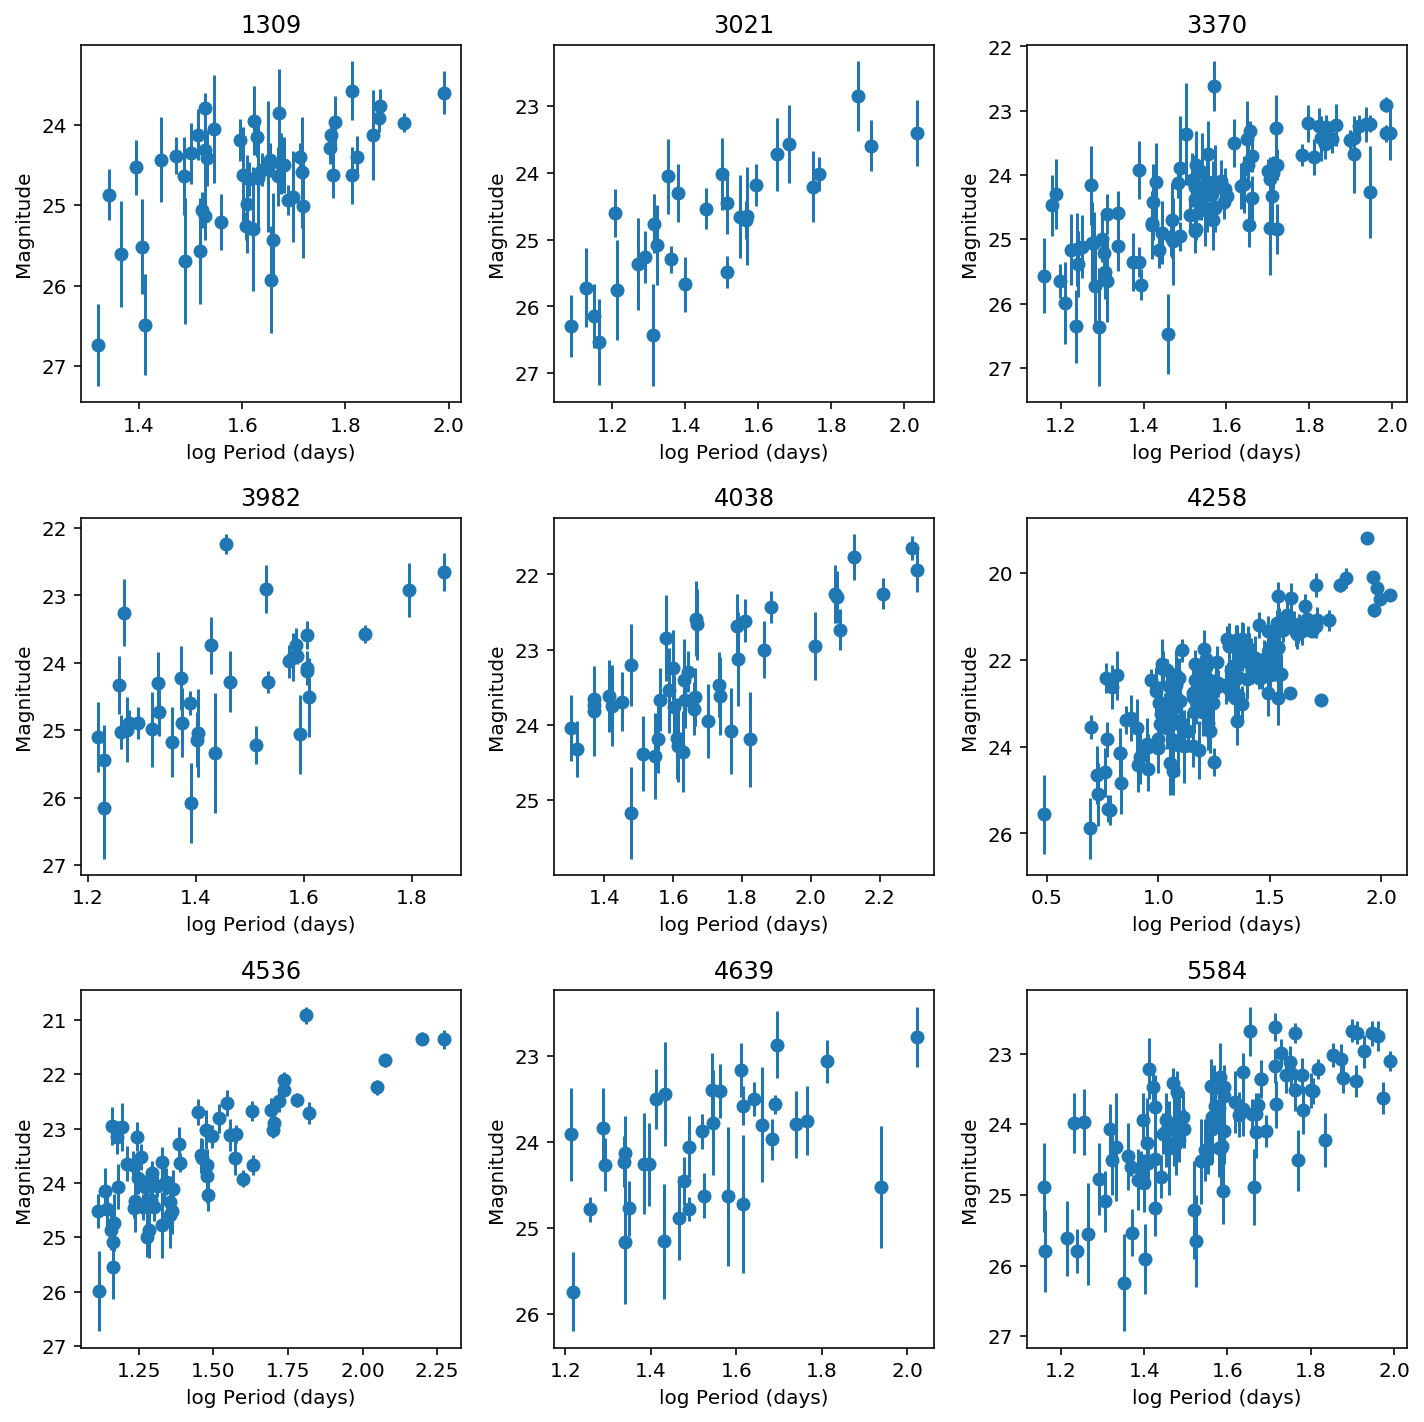

In [4]:
fig = plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(3,3, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.01)
axs = axs.ravel()

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    
    axs[i].invert_yaxis()
    axs[i].set_xlabel('log Period (days)')
    axs[i].set_ylabel('Magnitude')
    axs[i].errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o')
    axs[i].set_title(ID)
    
fig.tight_layout()

Least-squares estimates for 1309
m = -1.905 ± 0.253
b = 27.627 ± 0.427
Least-squares estimates for 3021
m = -2.881 ± 0.339
b = 29.050 ± 0.509
Least-squares estimates for 3370
m = -3.026 ± 0.128
b = 29.078 ± 0.217
Least-squares estimates for 3982
m = -2.718 ± 0.282
b = 28.152 ± 0.431
Least-squares estimates for 4038
m = -2.489 ± 0.178
b = 27.530 ± 0.332
Least-squares estimates for 4258
m = -2.948 ± 0.062
b = 26.265 ± 0.096
Least-squares estimates for 4536
m = -2.835 ± 0.090
b = 27.576 ± 0.148
Least-squares estimates for 4639
m = -2.627 ± 0.269
b = 28.059 ± 0.418
Least-squares estimates for 5584
m = -2.788 ± 0.136
b = 28.274 ± 0.228


<Figure size 720x720 with 0 Axes>

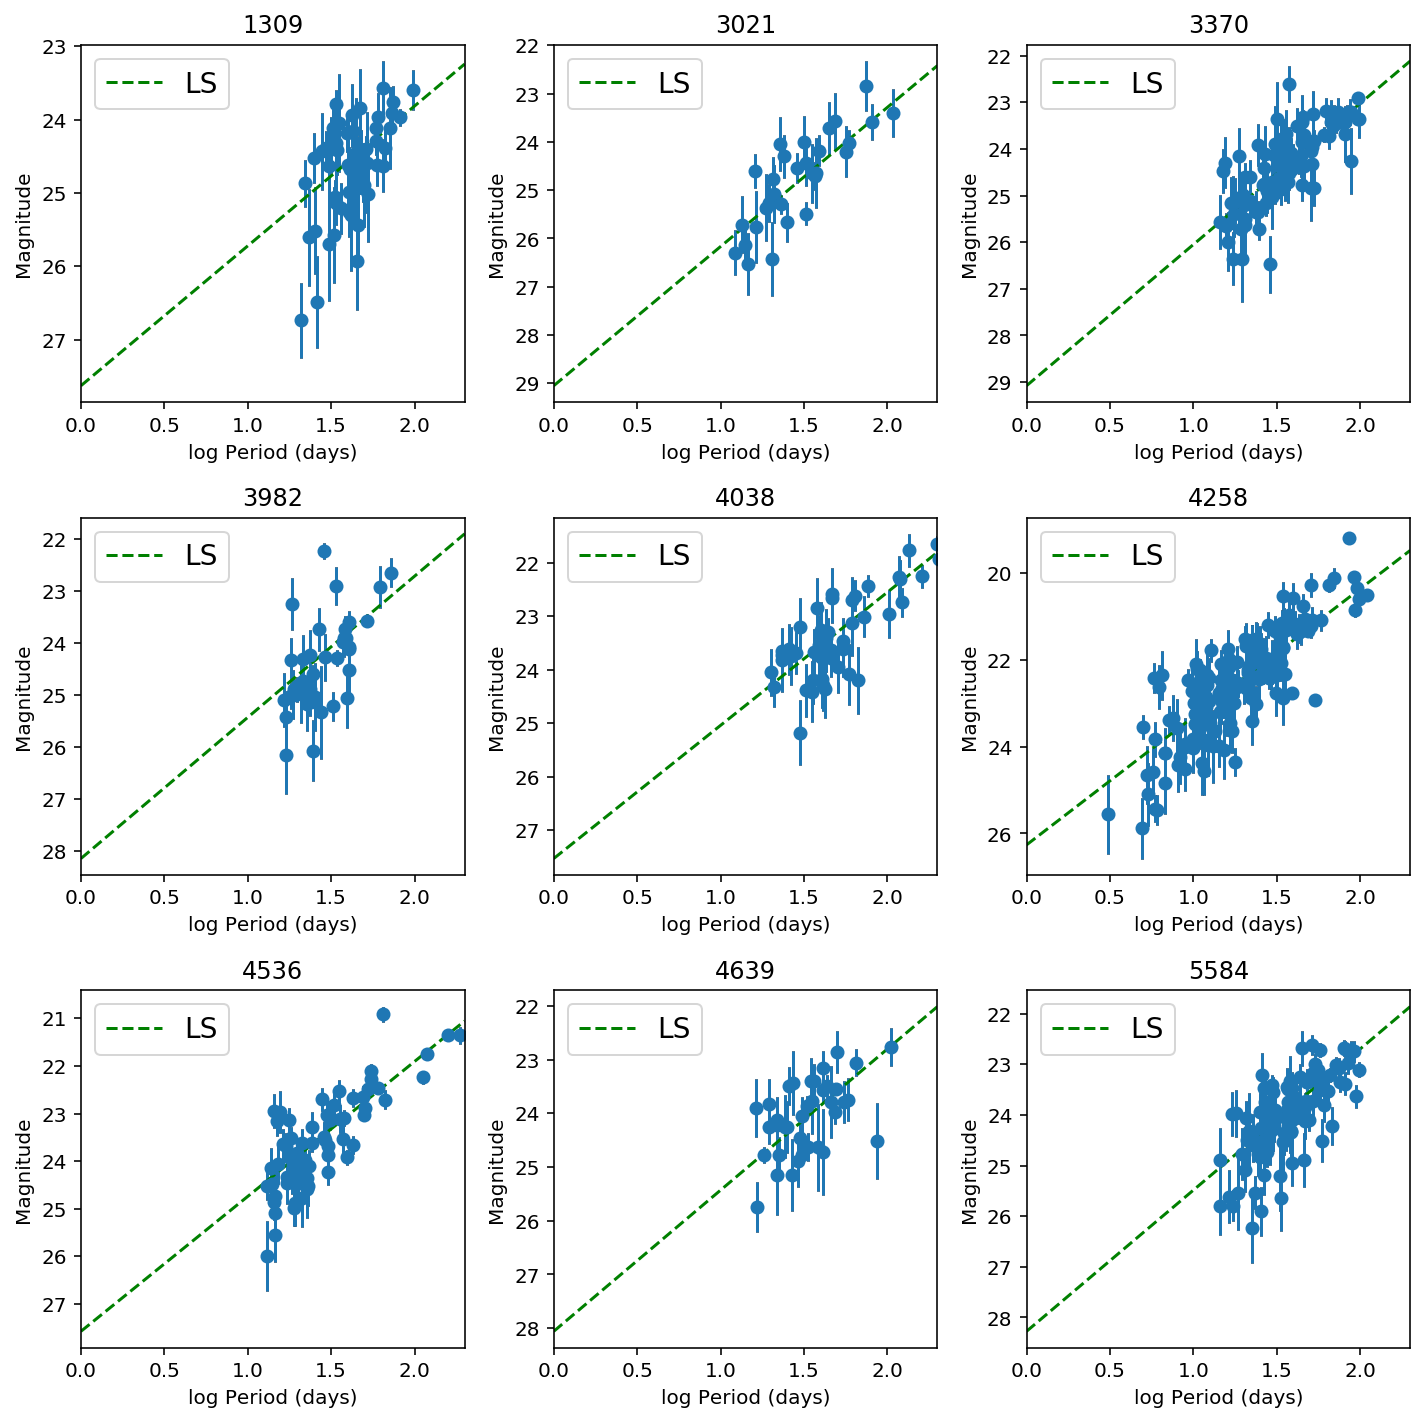

In [12]:
fig = plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(3,3, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.01)
axs = axs.ravel()
x0 = np.linspace(0, 2.3, 101)

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    
    x = np.array(logP)
    y = np.array(mobs)
    yerr = np.array(sigma_obs)
    
    #See Reiss et al 2009 eqs 3, 4, 5 for matrix equation
    A = np.vander(x, 2)
    C = np.diag(yerr * yerr)
    ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
    cov = np.linalg.inv(ATA)
    w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
    print("Least-squares estimates for", ID) #least squares fit for all galaxies
    print("m = {0:.3f} ± {1:.3f}".format(w[0], np.sqrt(cov[0, 0])))
    print("b = {0:.3f} ± {1:.3f}".format(w[1], np.sqrt(cov[1, 1])))
    
    axs[i].invert_yaxis()
    axs[i].set_xlabel('log Period (days)')
    axs[i].set_ylabel('Magnitude')
    
    axs[i].errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    axs[i].plot(x0, np.dot(np.vander(x0, 2), w), "--g", label="LS") #least squares fit
    axs[i].legend(fontsize=14)
    axs[i].set_xlim(0, 2.3)
    axs[i].errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o')
    axs[i].set_title(ID)
    
fig.tight_layout()

In [79]:
#make sure this log likelihood matches what I wrote above!

def log_likelihood(theta, x, y, yerr):
    m, b, log_f = theta
    model = m * x + b
    sigma2 = yerr ** 2 + model ** 2 * np.exp(2 * log_f)
    return -0.5 * np.sum((y - model) ** 2 / sigma2 + np.log(sigma2))

In [84]:
#model params m,b,log f
#assume uniform priors sensible for data

def log_prior(theta):
    m, b, log_f = theta
    if -5.0 < m < 0 and 20.0 < b < 30.0 and -7.0 < log_f < 0.0:
        return 0.0
    return -np.inf

In [85]:
def log_probability(theta, x, y, yerr):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)

In [57]:
mT = np.array((-2.2, -3.0, -3.0, -3.3, -2.5, -3.2, -3.0, -2.3, -2.8))
bT = np.array((28.1, 29.2, 29.0, 29.0, 27.5, 26.2, 27.9, 27.5, 28.0))
fT = np.array((0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05))

for i, ID in enumerate(hosts):
    m_true = mT[i]
    b_true = bT[i]
    f_true = fT[i]

1309 [-2.2 -3.  -3.  -3.3 -2.5 -3.2 -3.  -2.3 -2.8] [28.1 29.2 29.  29.  27.5 26.2 27.9 27.5 28. ]
3021 [-2.2 -3.  -3.  -3.3 -2.5 -3.2 -3.  -2.3 -2.8] [28.1 29.2 29.  29.  27.5 26.2 27.9 27.5 28. ]
3370 [-2.2 -3.  -3.  -3.3 -2.5 -3.2 -3.  -2.3 -2.8] [28.1 29.2 29.  29.  27.5 26.2 27.9 27.5 28. ]
3982 [-2.2 -3.  -3.  -3.3 -2.5 -3.2 -3.  -2.3 -2.8] [28.1 29.2 29.  29.  27.5 26.2 27.9 27.5 28. ]
4038 [-2.2 -3.  -3.  -3.3 -2.5 -3.2 -3.  -2.3 -2.8] [28.1 29.2 29.  29.  27.5 26.2 27.9 27.5 28. ]
4258 [-2.2 -3.  -3.  -3.3 -2.5 -3.2 -3.  -2.3 -2.8] [28.1 29.2 29.  29.  27.5 26.2 27.9 27.5 28. ]
4536 [-2.2 -3.  -3.  -3.3 -2.5 -3.2 -3.  -2.3 -2.8] [28.1 29.2 29.  29.  27.5 26.2 27.9 27.5 28. ]
4639 [-2.2 -3.  -3.  -3.3 -2.5 -3.2 -3.  -2.3 -2.8] [28.1 29.2 29.  29.  27.5 26.2 27.9 27.5 28. ]
5584 [-2.2 -3.  -3.  -3.3 -2.5 -3.2 -3.  -2.3 -2.8] [28.1 29.2 29.  29.  27.5 26.2 27.9 27.5 28. ]


Maximum likelihood estimates for 1309
m = -2.153
b = 28.066
f = 0.013
Maximum likelihood estimates for 3021
m = -2.967
b = 29.129
f = 0.012
Maximum likelihood estimates for 3370
m = -2.987
b = 29.006
f = 0.010
Maximum likelihood estimates for 3982
m = -3.267
b = 29.069
f = 0.024
Maximum likelihood estimates for 4038
m = -2.467
b = 27.504
f = 0.006
Maximum likelihood estimates for 4258
m = -3.154
b = 26.511
f = 0.024
Maximum likelihood estimates for 4536
m = -2.915
b = 27.733
f = 0.020
Maximum likelihood estimates for 4639
m = -2.297
b = 27.509
f = 0.013
Maximum likelihood estimates for 5584
m = -2.794
b = 28.336
f = 0.015


<Figure size 720x720 with 0 Axes>

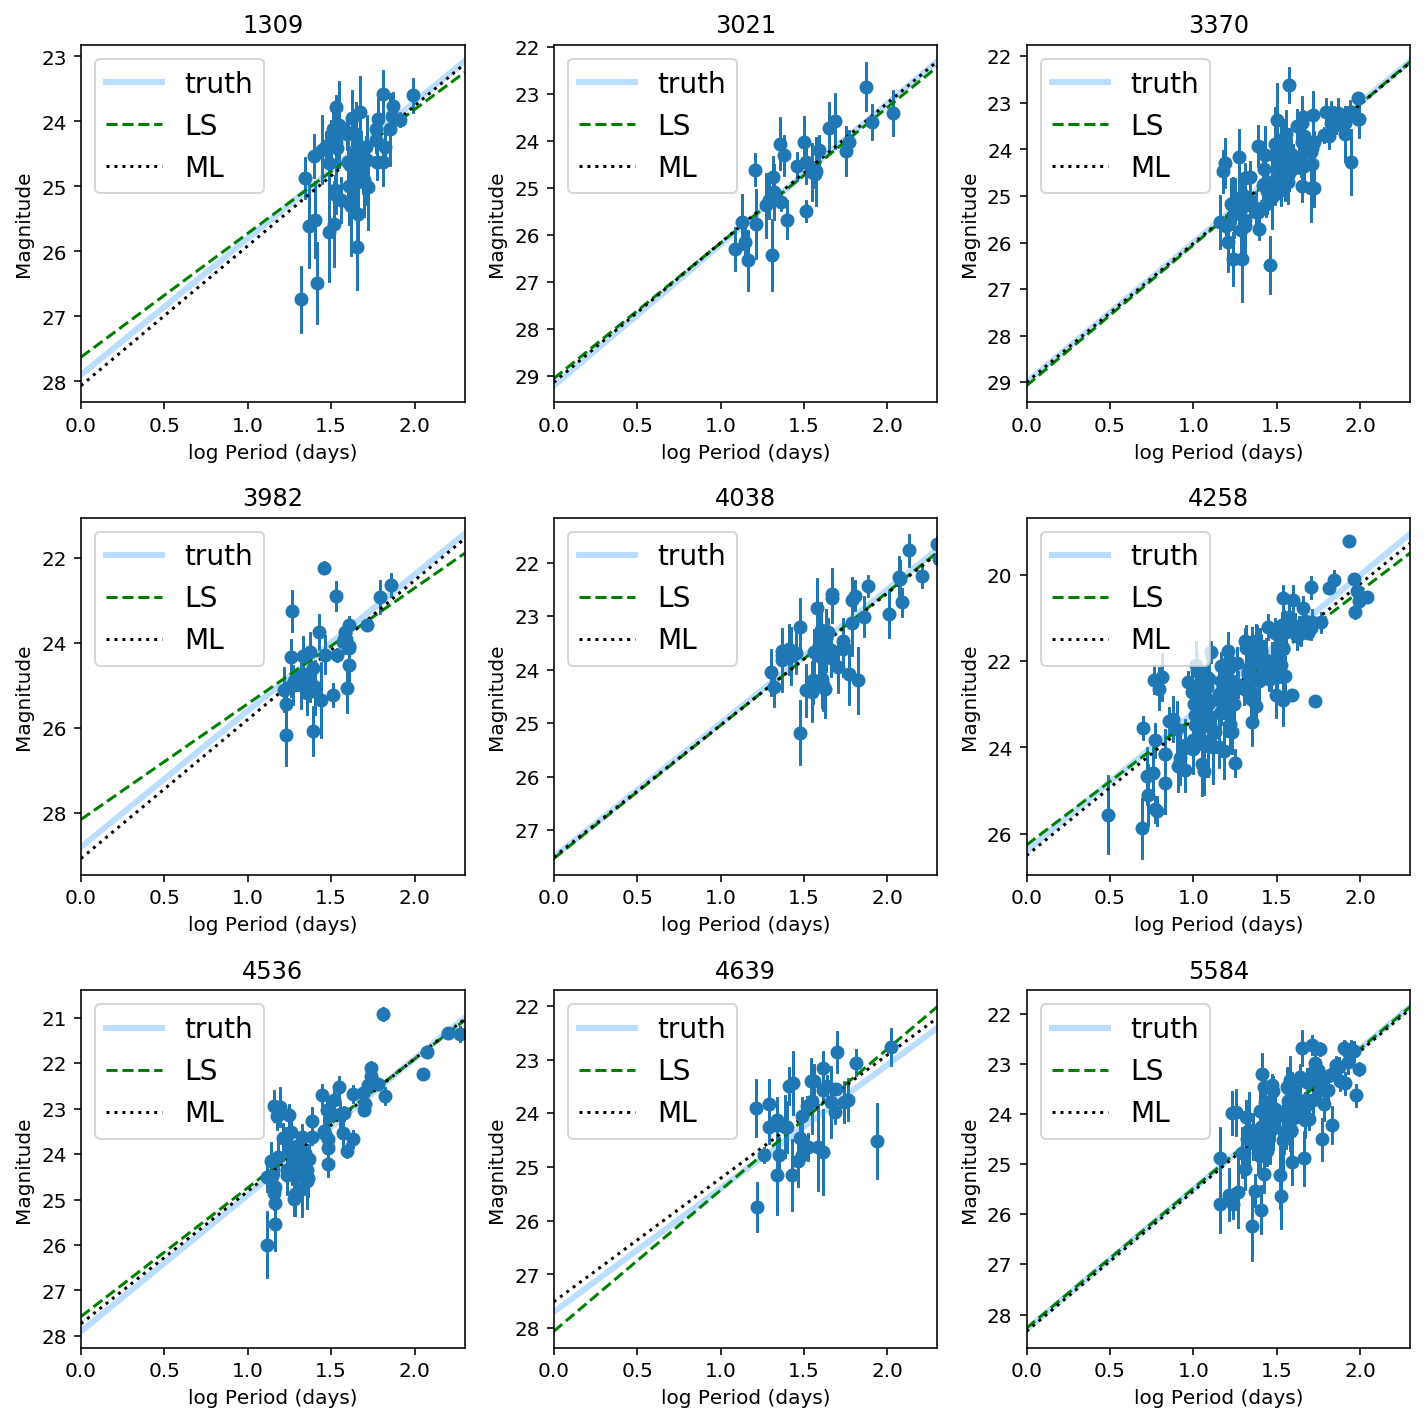

In [86]:
from scipy.optimize import minimize
import emcee

fig = plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(3,3, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.01)
axs = axs.ravel()

#choose best guess "truth" parameters for model for MLE fit based off LS estimate
mT = np.array((-2.1, -3.0, -3.0, -3.2, -2.5, -3.2, -3.0, -2.3, -2.8))
bT = np.array((27.9, 29.2, 29.0, 28.8, 27.5, 26.4, 27.9, 27.7, 28.3))
fT = np.array((0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05))

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    
    x = np.array(logP)
    y = np.array(mobs)
    yerr = np.array(sigma_obs)
    
    A = np.vander(x, 2)
    C = np.diag(yerr * yerr)
    ATA = np.dot(A.T, A / (yerr ** 2)[:, None])
    cov = np.linalg.inv(ATA)
    w = np.linalg.solve(ATA, np.dot(A.T, y / yerr ** 2))
    
    #make sure each galaxy has my best guess truth fit from above arrays
    m_true = mT[i]
    b_true = bT[i]
    f_true = fT[i]
    
    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
    soln = minimize(nll, initial, args=(x, y, yerr))
    m_ml, b_ml, log_f_ml = soln.x

    print("Maximum likelihood estimates for", ID)
    print("m = {0:.3f}".format(m_ml))
    print("b = {0:.3f}".format(b_ml))
    print("f = {0:.3f}".format(np.exp(log_f_ml)))

    axs[i].invert_yaxis()
    axs[i].set_xlabel('log Period (days)')
    axs[i].set_ylabel('Magnitude')
    
    #Should look similar-ish to Reiss et al (2011) Fig 7. 
    #If good, do emcee for MCMC fit and then actually compare!
    axs[i].errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    axs[i].plot(x0, m_true * x0 + b_true, "dodgerblue", alpha=0.3, lw=3, label="truth") #fit from "true" params
    axs[i].plot(x0, np.dot(np.vander(x0, 2), w), "--g", label="LS") #Least squares
    axs[i].plot(x0, np.dot(np.vander(x0, 2), [m_ml, b_ml]), ":k", label="ML") #MLE
    axs[i].legend(fontsize=14)
    axs[i].set_xlim(0, 2.3)
    axs[i].errorbar(logP, mobs, yerr=sigma_obs, linestyle='None', marker='o')
    axs[i].set_title(ID)
    
fig.tight_layout()

100%|██████████| 5000/5000 [00:09<00:00, 525.76it/s]


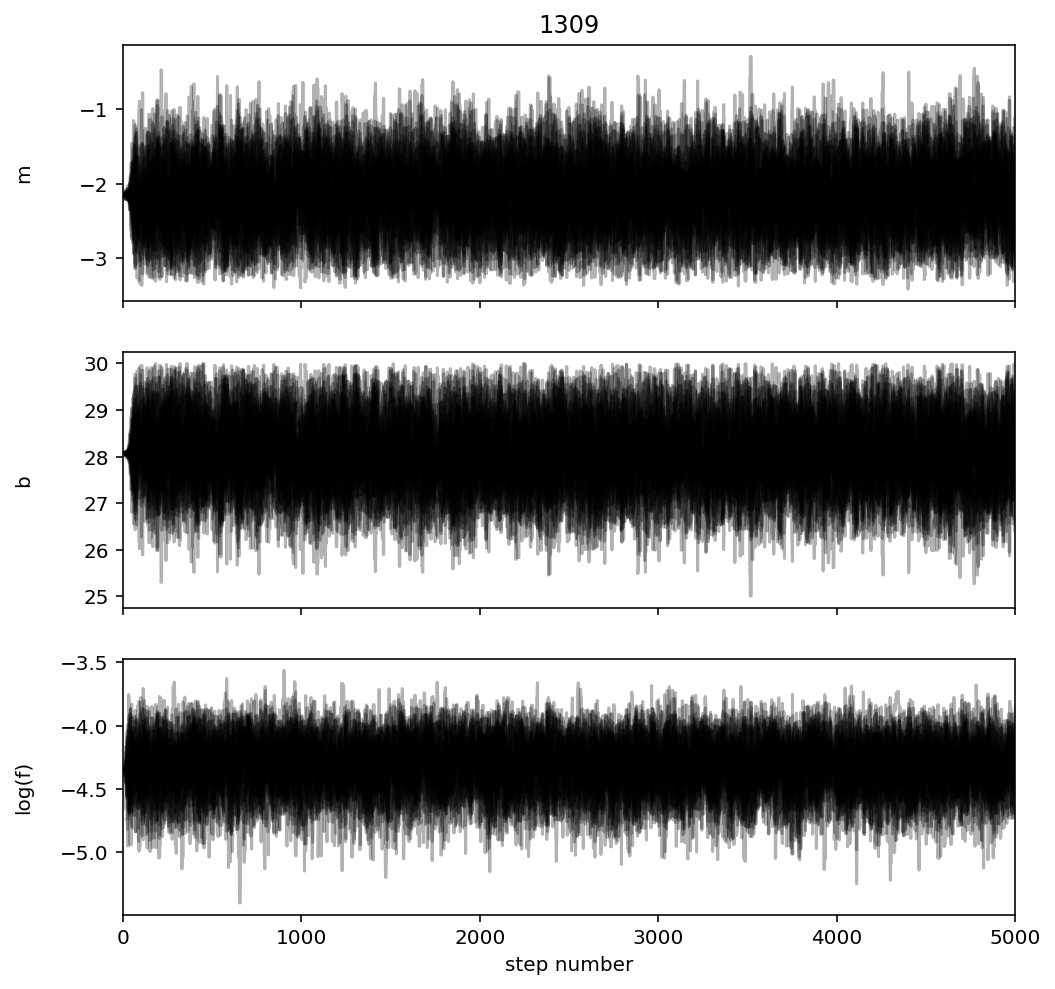

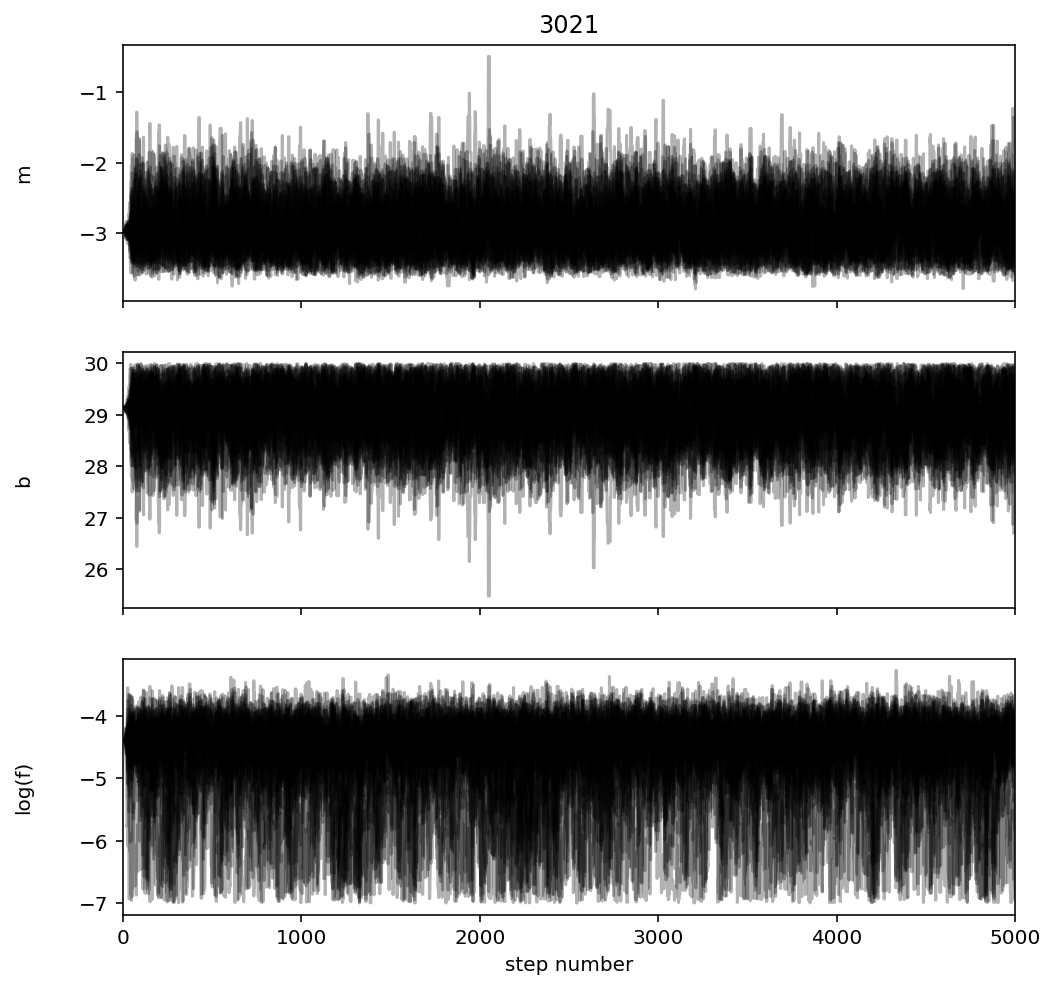

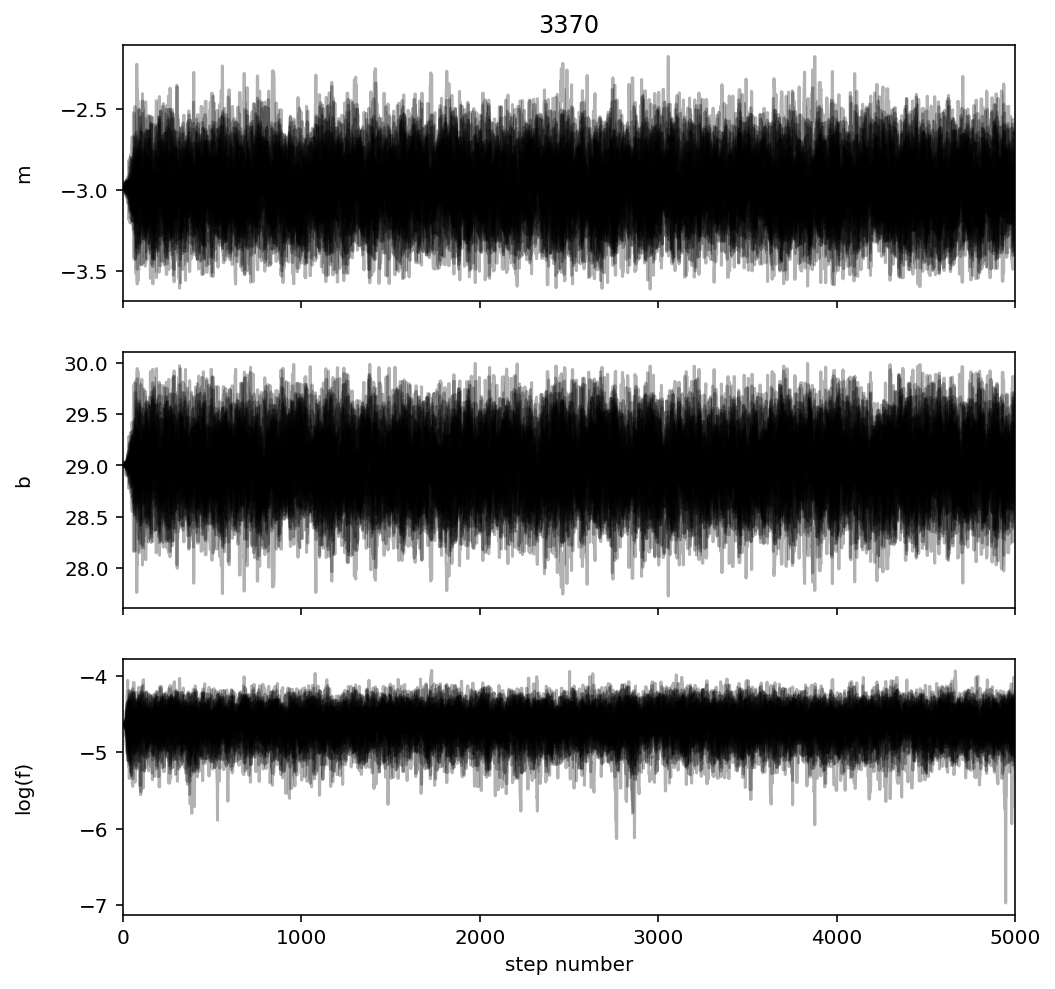

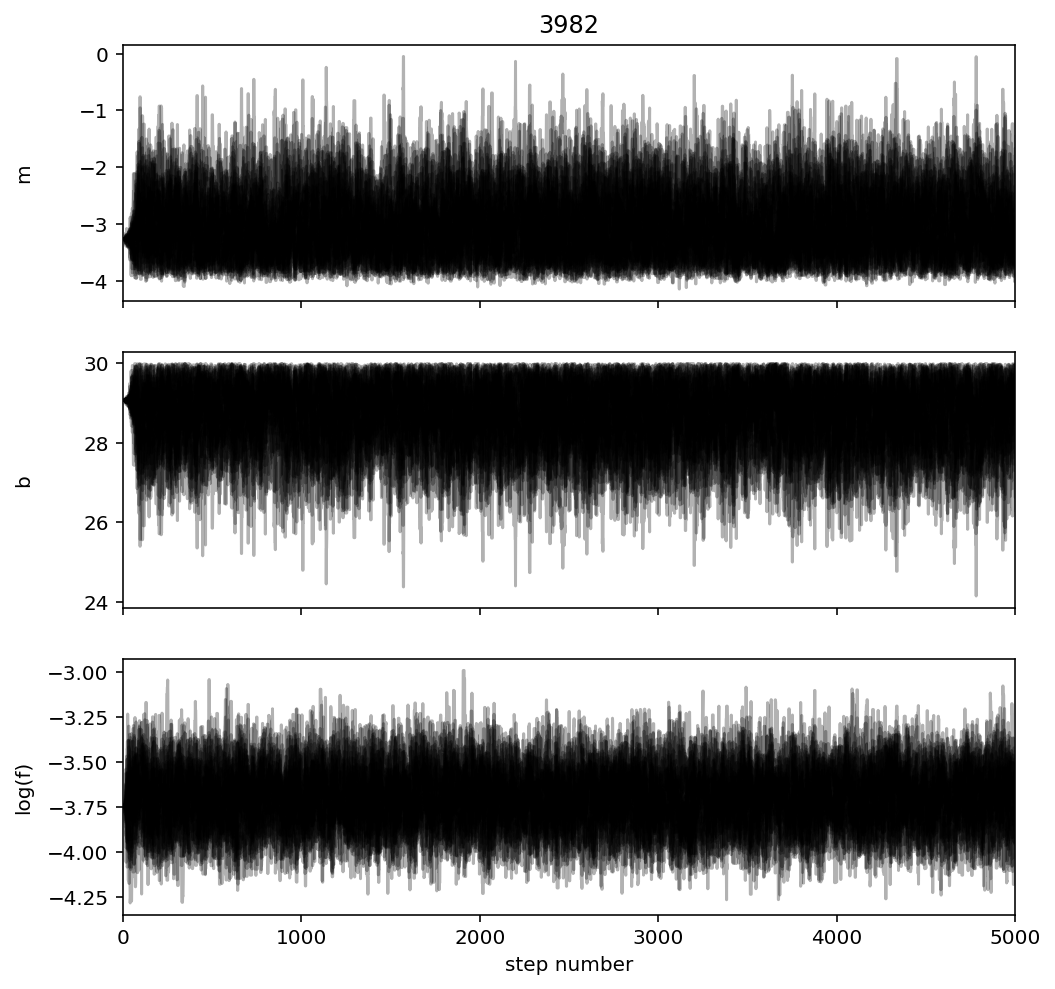

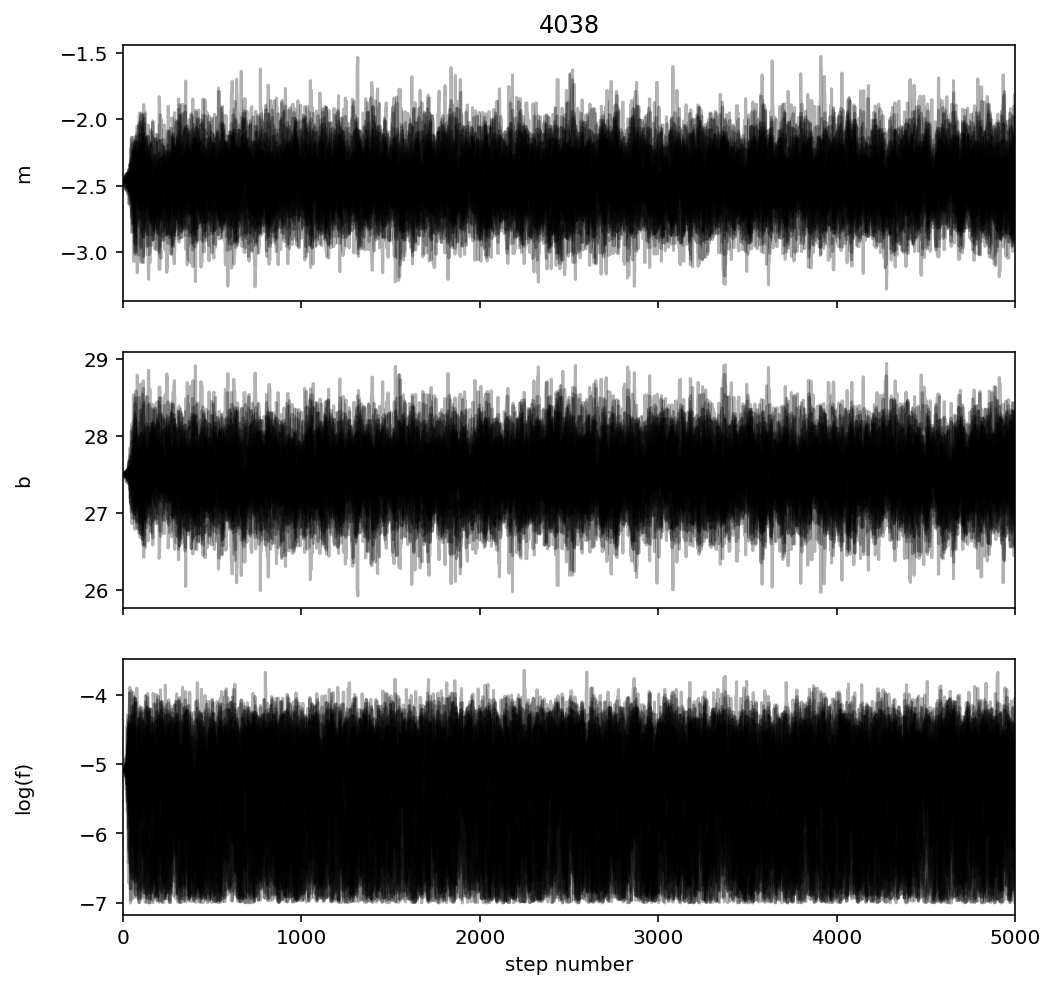

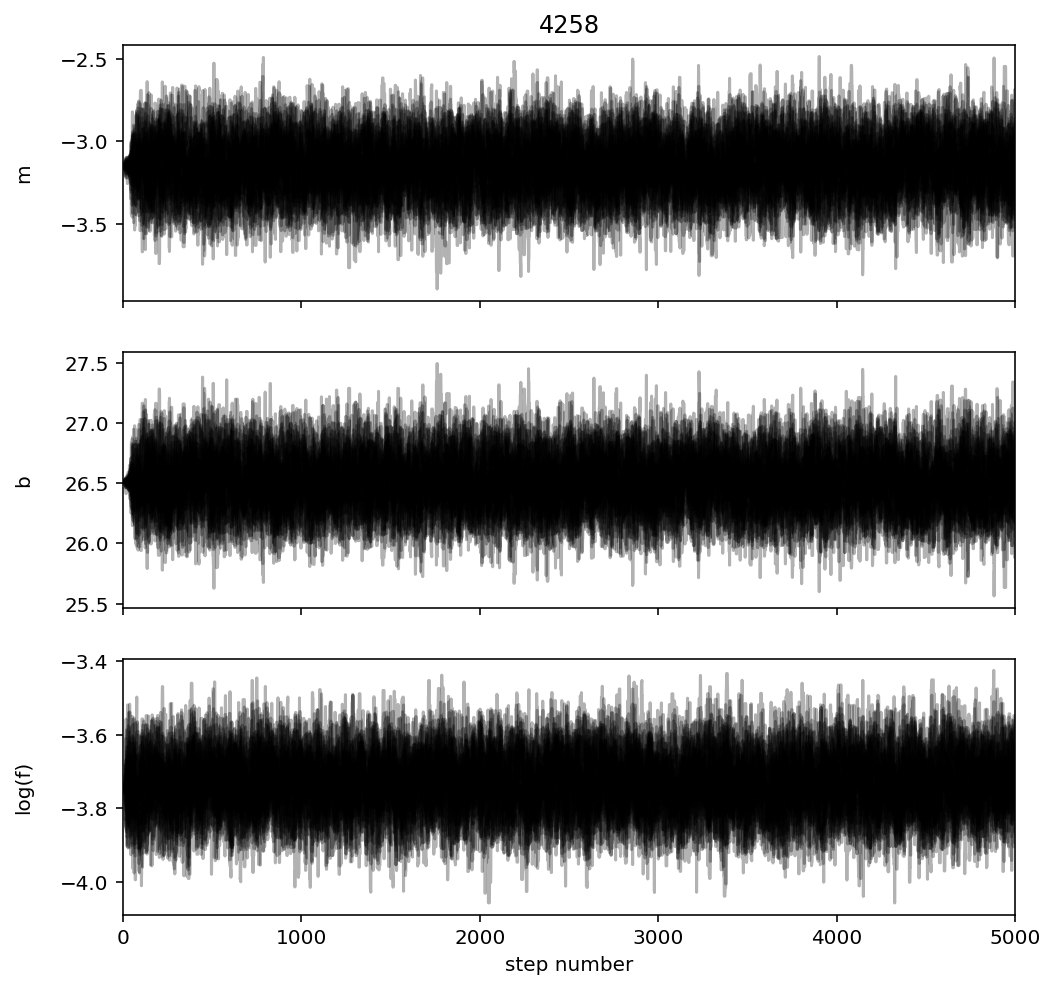

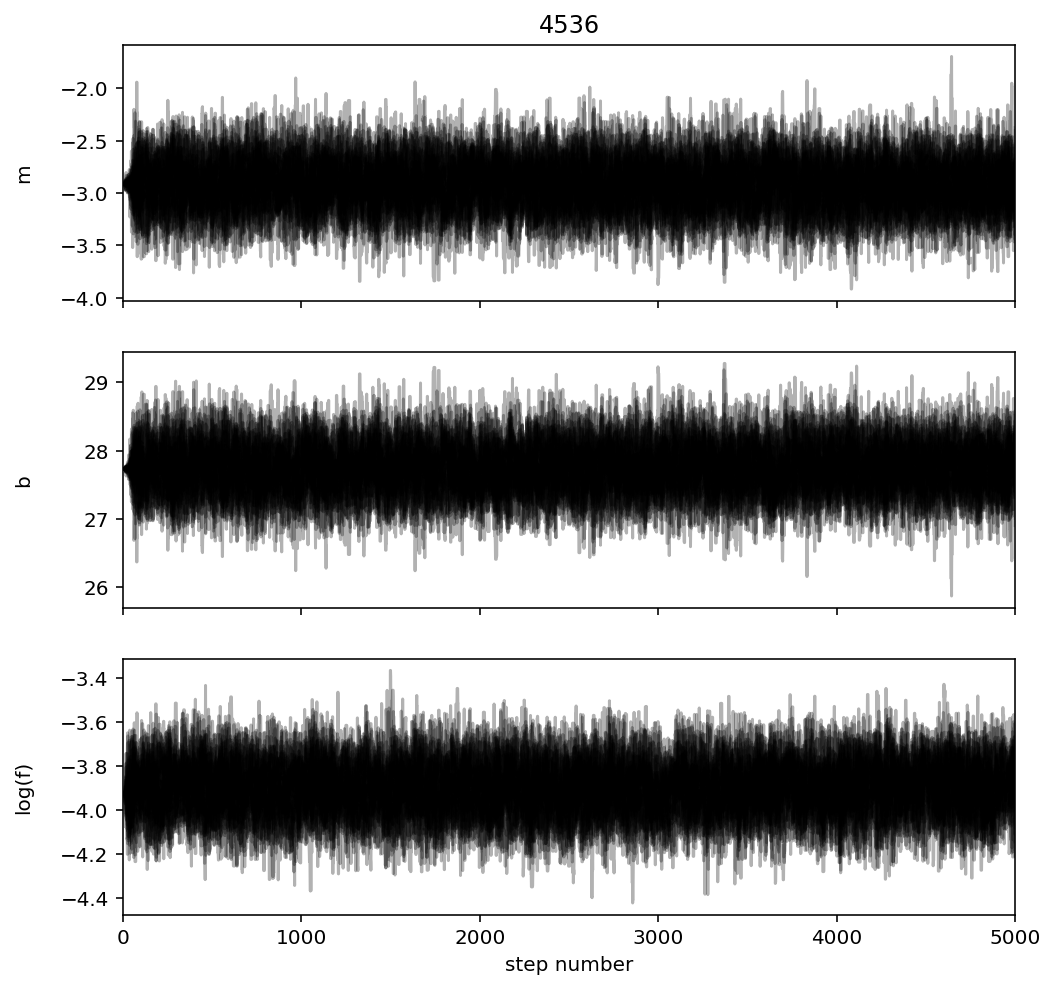

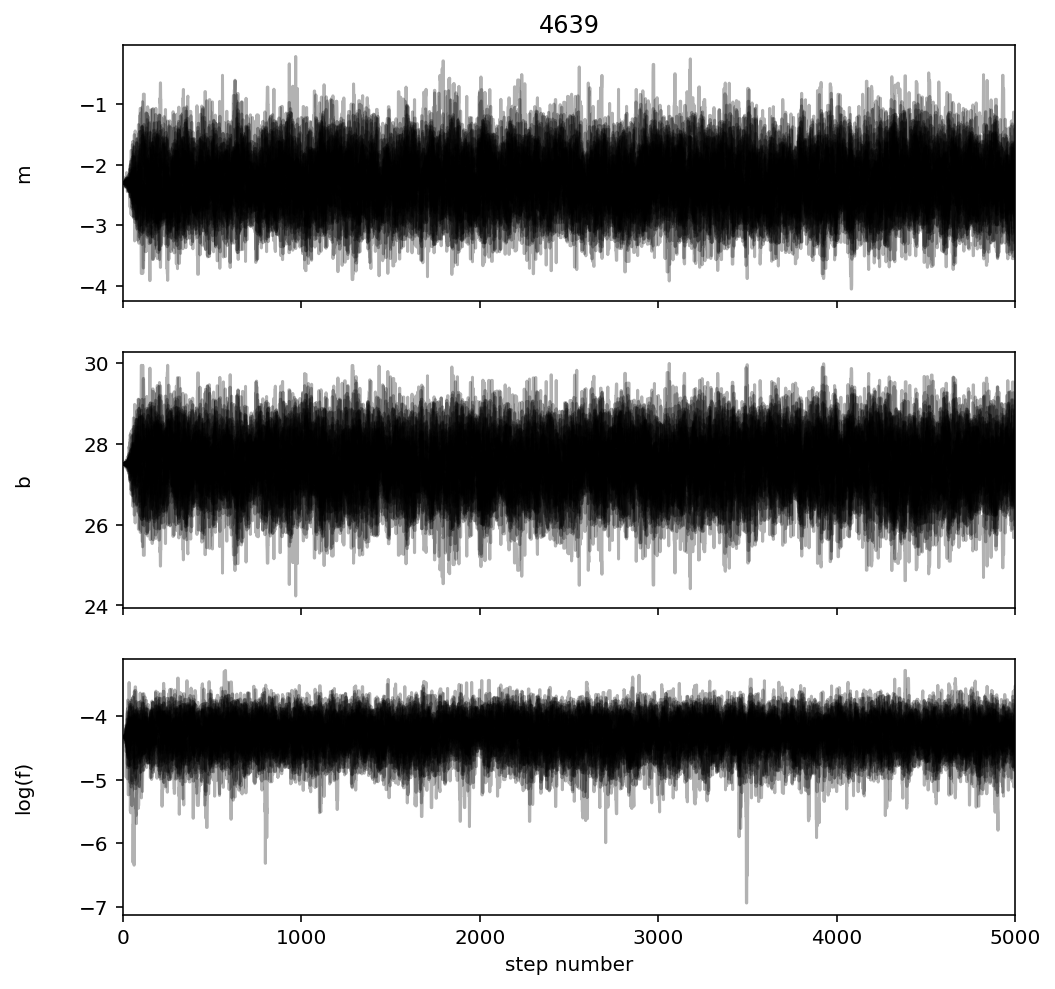

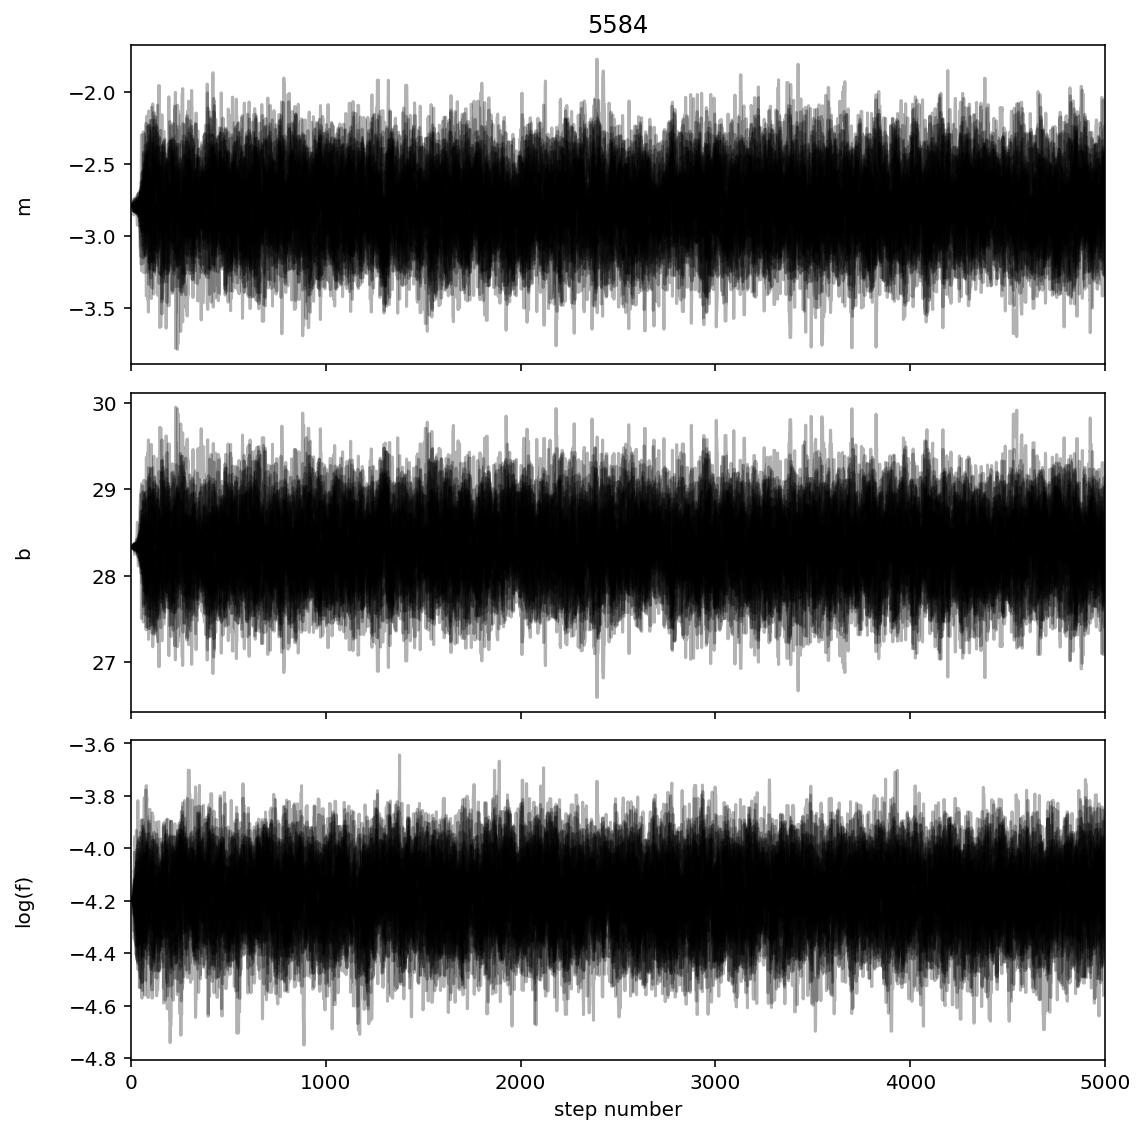

In [87]:
from scipy.optimize import minimize
import emcee
import corner

mT = np.array((-2.1, -3.0, -3.0, -3.2, -2.5, -3.2, -3.0, -2.3, -2.8))
bT = np.array((27.9, 29.2, 29.0, 28.8, 27.5, 26.4, 27.9, 27.7, 28.3))
fT = np.array((0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05))

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    
    x = np.array(logP)
    y = np.array(mobs)
    yerr = np.array(sigma_obs)
    
    m_true = mT[i]
    b_true = bT[i]
    f_true = fT[i]
    
    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
    soln = minimize(nll, initial, args=(x, y, yerr))
    m_ml, b_ml, log_f_ml = soln.x

    pos = soln.x + 1e-4 * np.random.randn(32, 3)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
    sampler.run_mcmc(pos, 5000, progress=True)
    
    fig, axes = plt.subplots(3, figsize=(8, 8), sharex=True)
    samples = sampler.get_chain()
    labels = ["m", "b", "log(f)"]
    
    for i in range(ndim):
        ax = axes[i]
        ax.plot(samples[:, :, i], "k", alpha=0.3)
        ax.set_xlim(0, len(samples))
        ax.set_ylabel(labels[i])
        ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number")
    axes[0].set_title(ID)
    
fig.tight_layout()

Most of my chains are reversible and stationary after burn in for each galaxy. Two of the $log f$ chains are not great, but because we are assuming strictly intrinsic Gaussian error, we can ignore this.

100%|██████████| 5000/5000 [00:08<00:00, 588.05it/s]


ID: 1309


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|██████████| 5000/5000 [00:08<00:00, 597.72it/s]


ID: 3021


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|██████████| 5000/5000 [00:09<00:00, 528.26it/s]


ID: 3370


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|██████████| 5000/5000 [00:08<00:00, 580.24it/s]


ID: 3982


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|██████████| 5000/5000 [00:09<00:00, 502.63it/s]


ID: 4038


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|██████████| 5000/5000 [00:11<00:00, 432.53it/s]


ID: 4258


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|██████████| 5000/5000 [00:09<00:00, 521.63it/s]


ID: 4536


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|██████████| 5000/5000 [00:11<00:00, 429.34it/s]


ID: 4639


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

100%|██████████| 5000/5000 [00:10<00:00, 478.00it/s]


ID: 5584


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<Figure size 720x720 with 0 Axes>

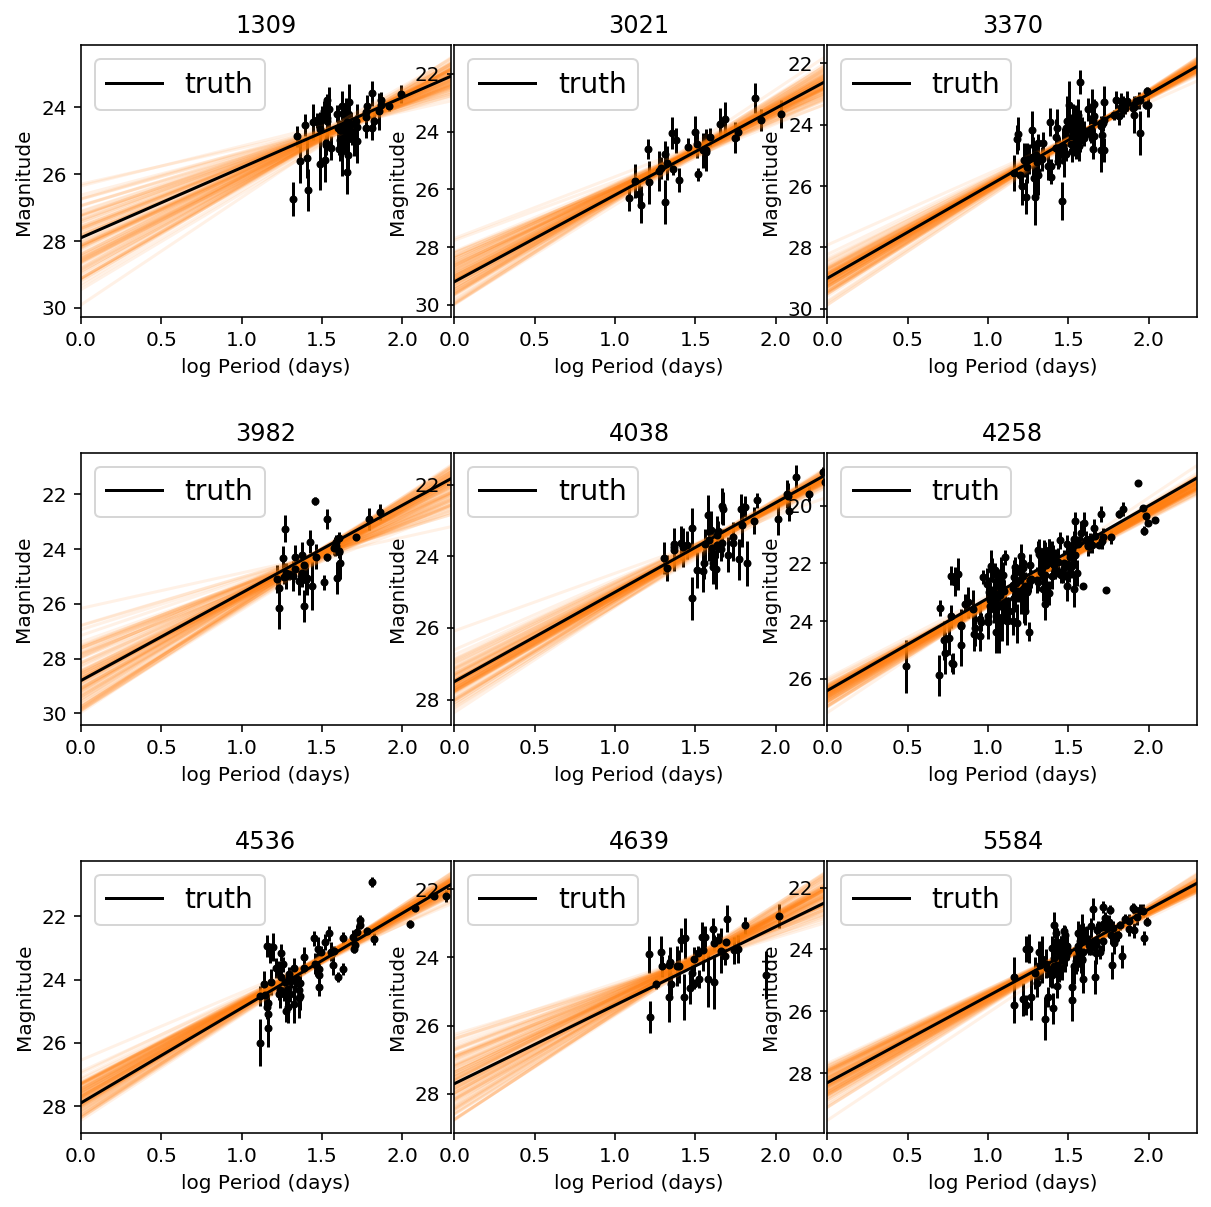

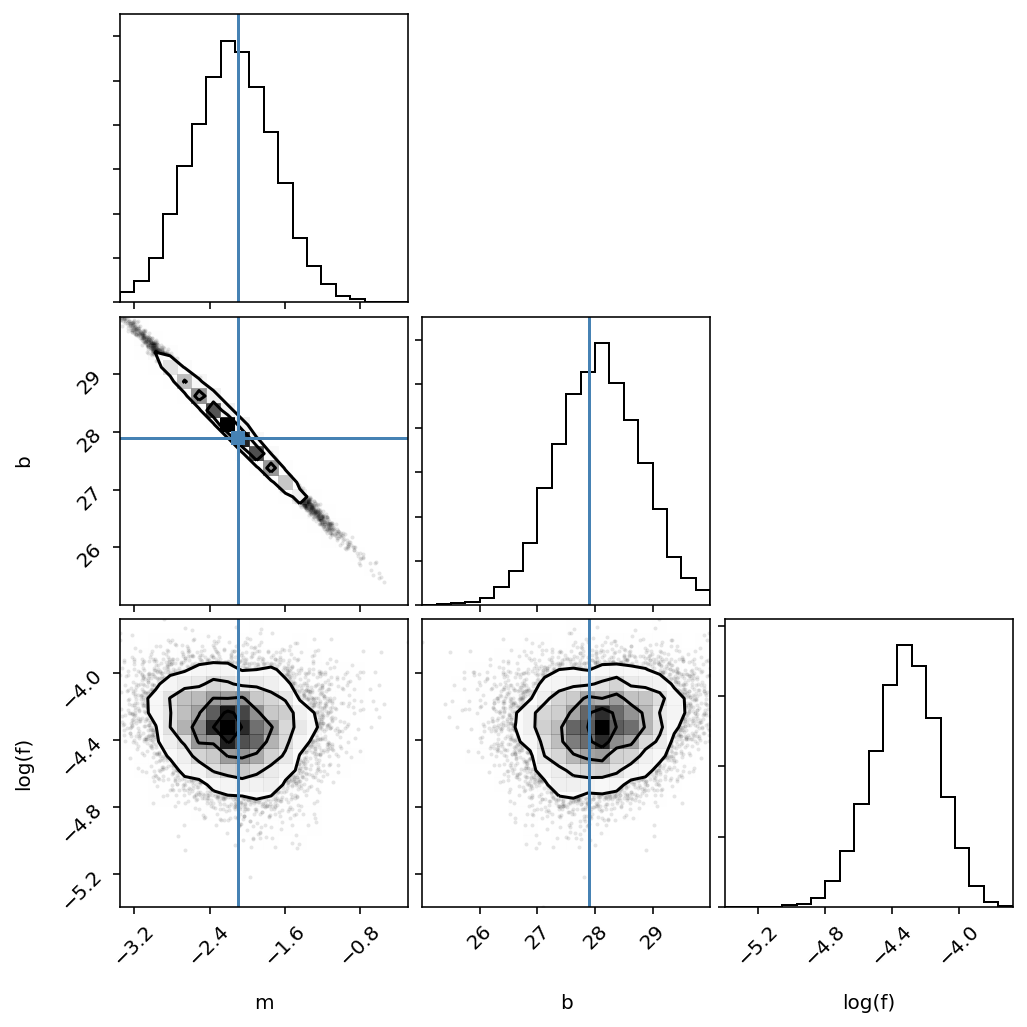

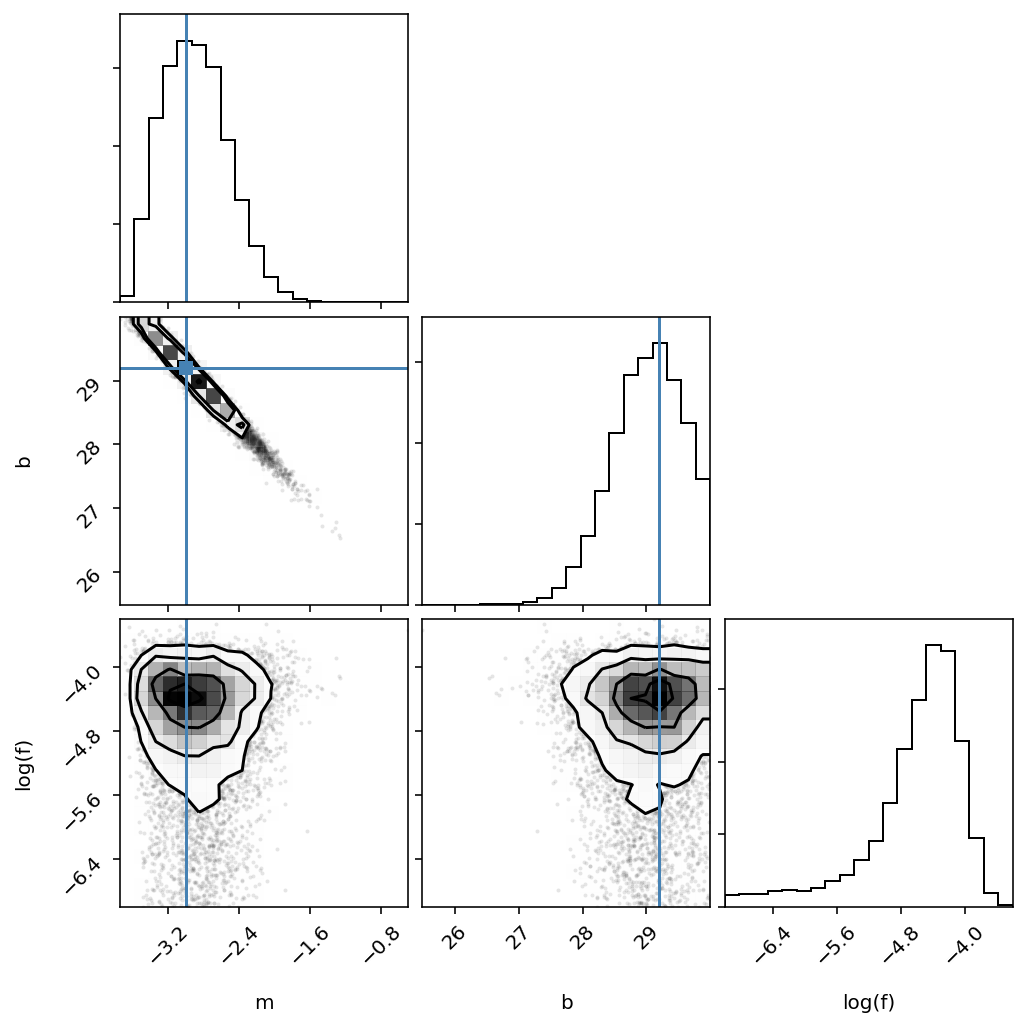

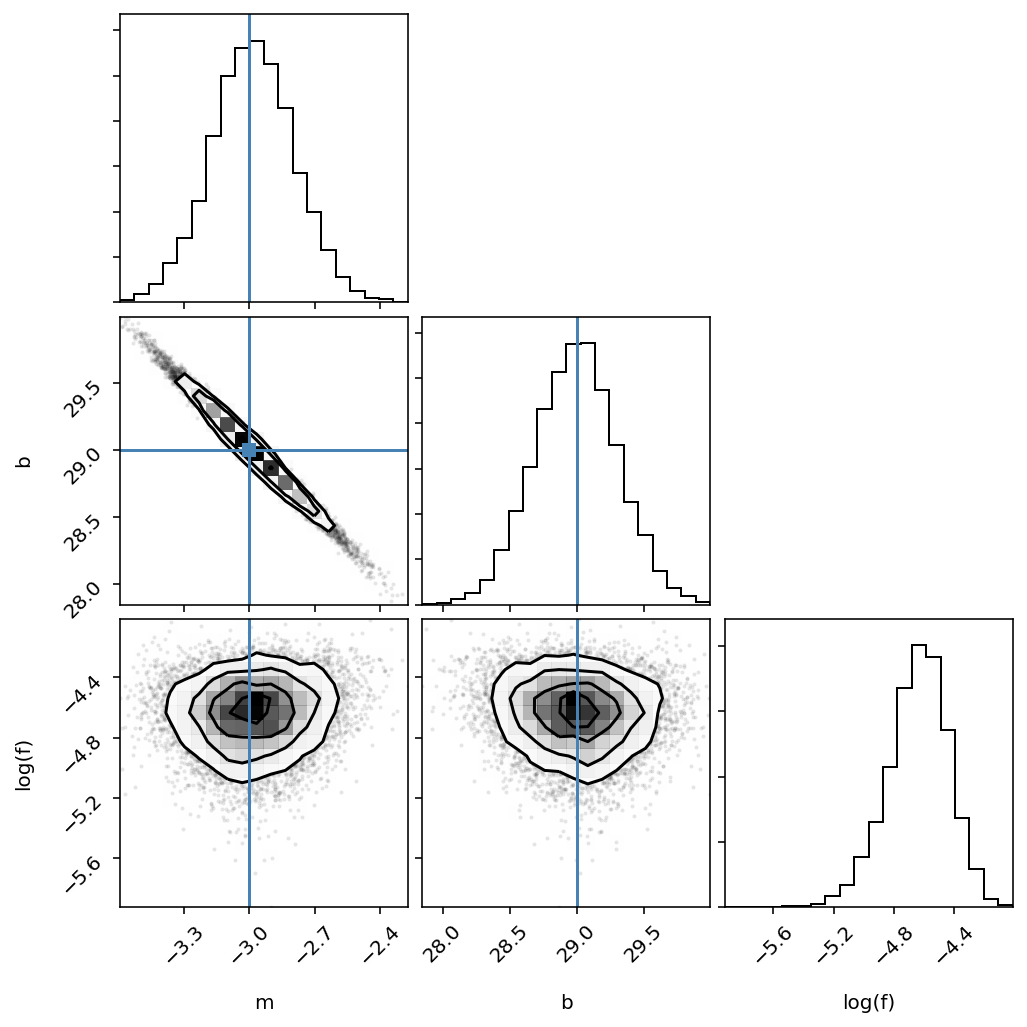

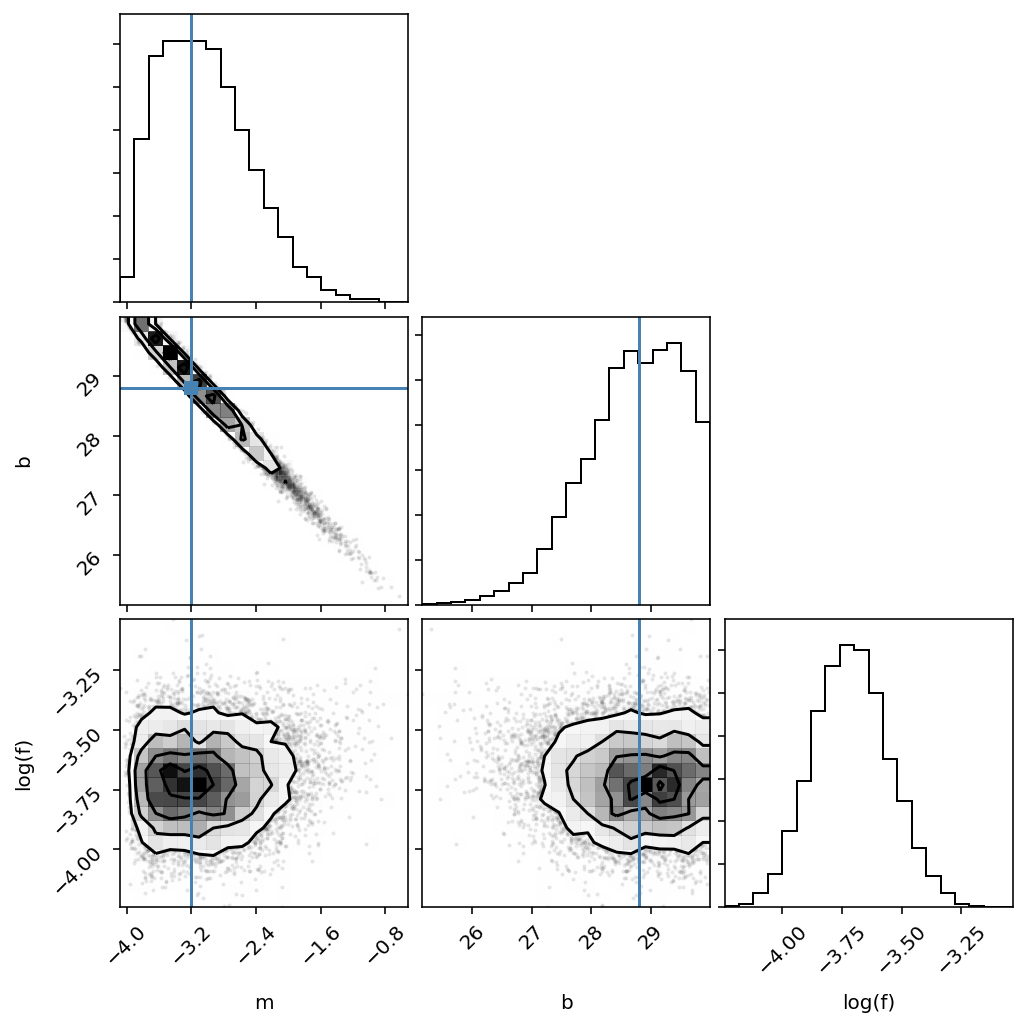

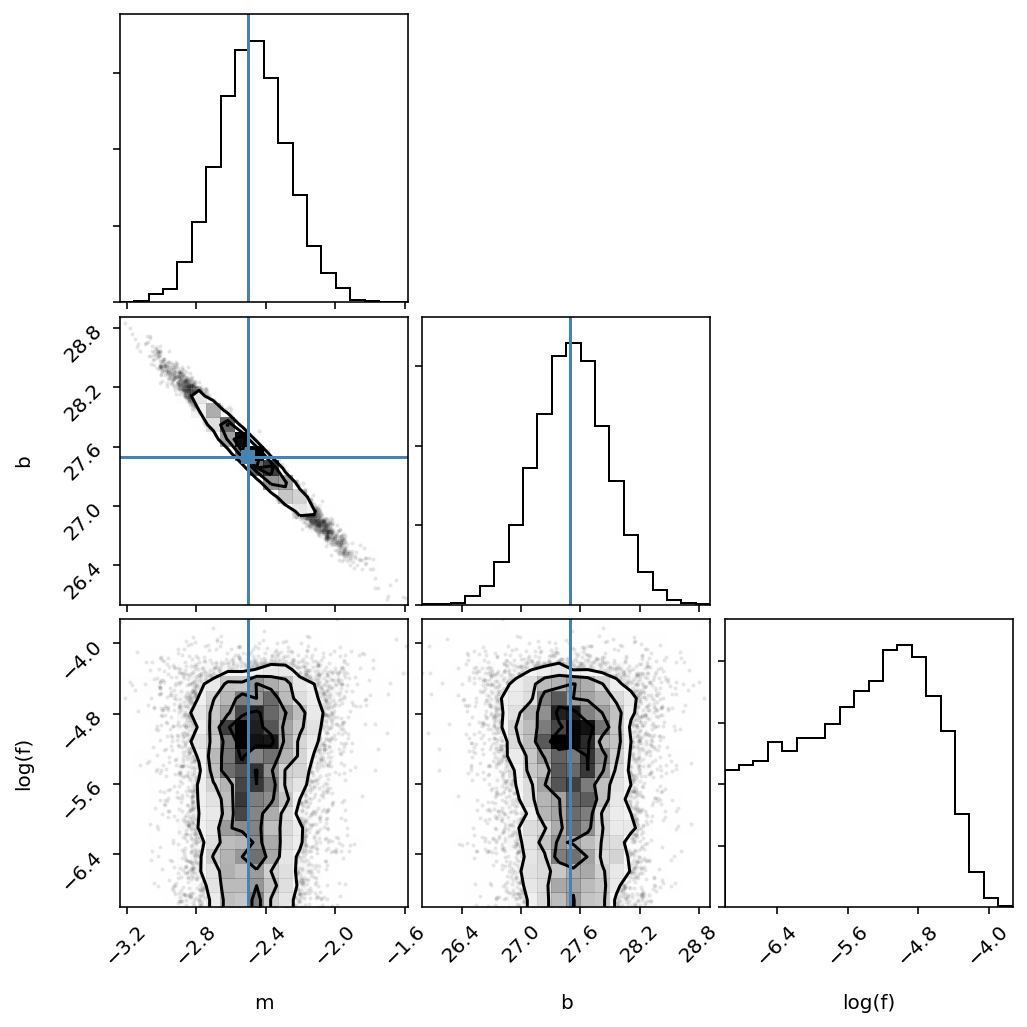

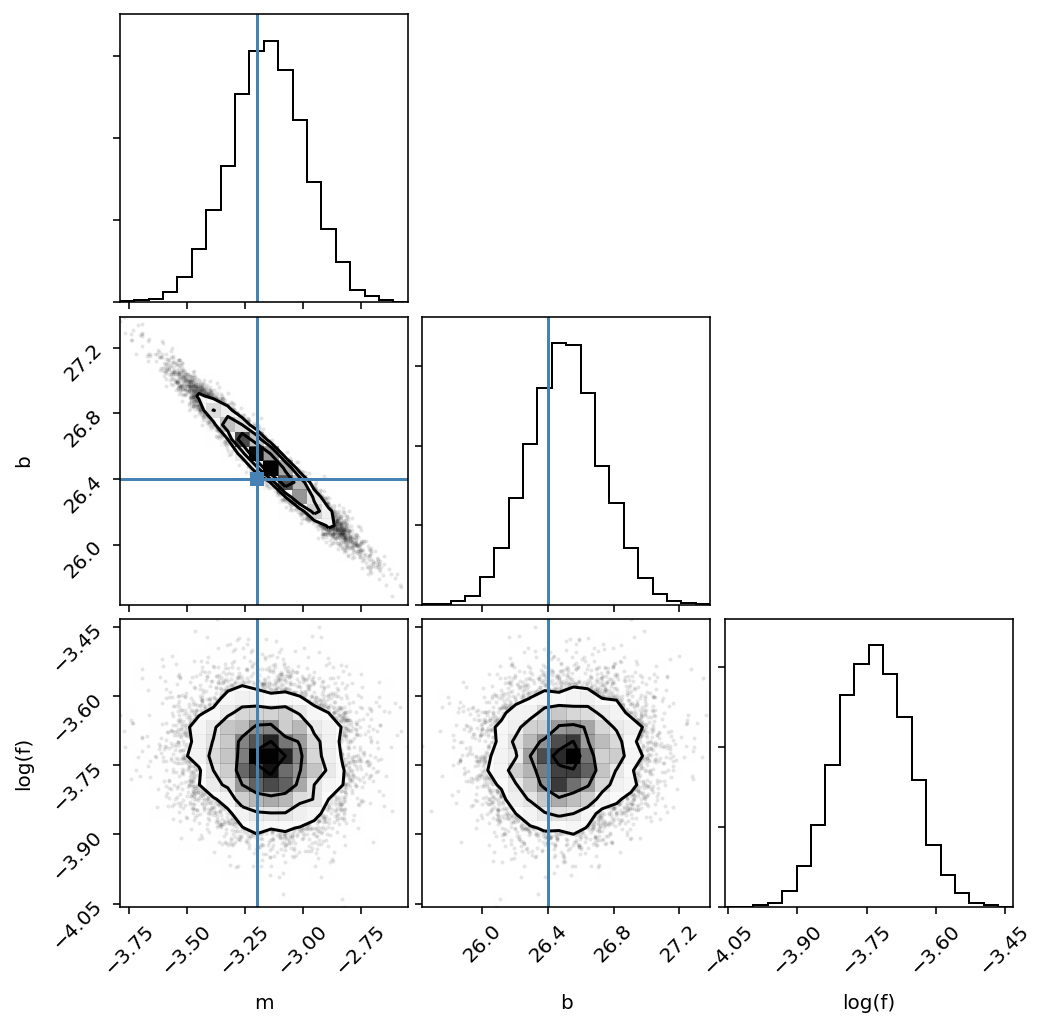

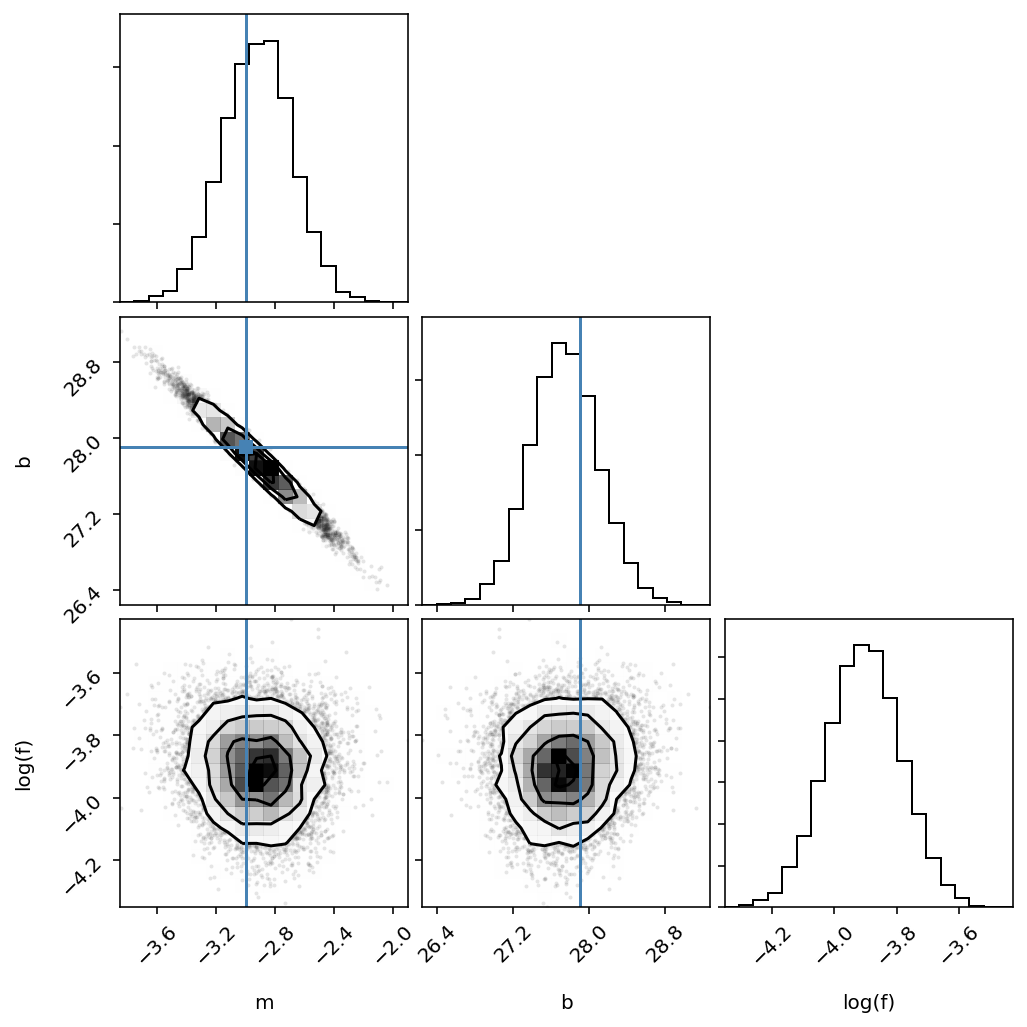

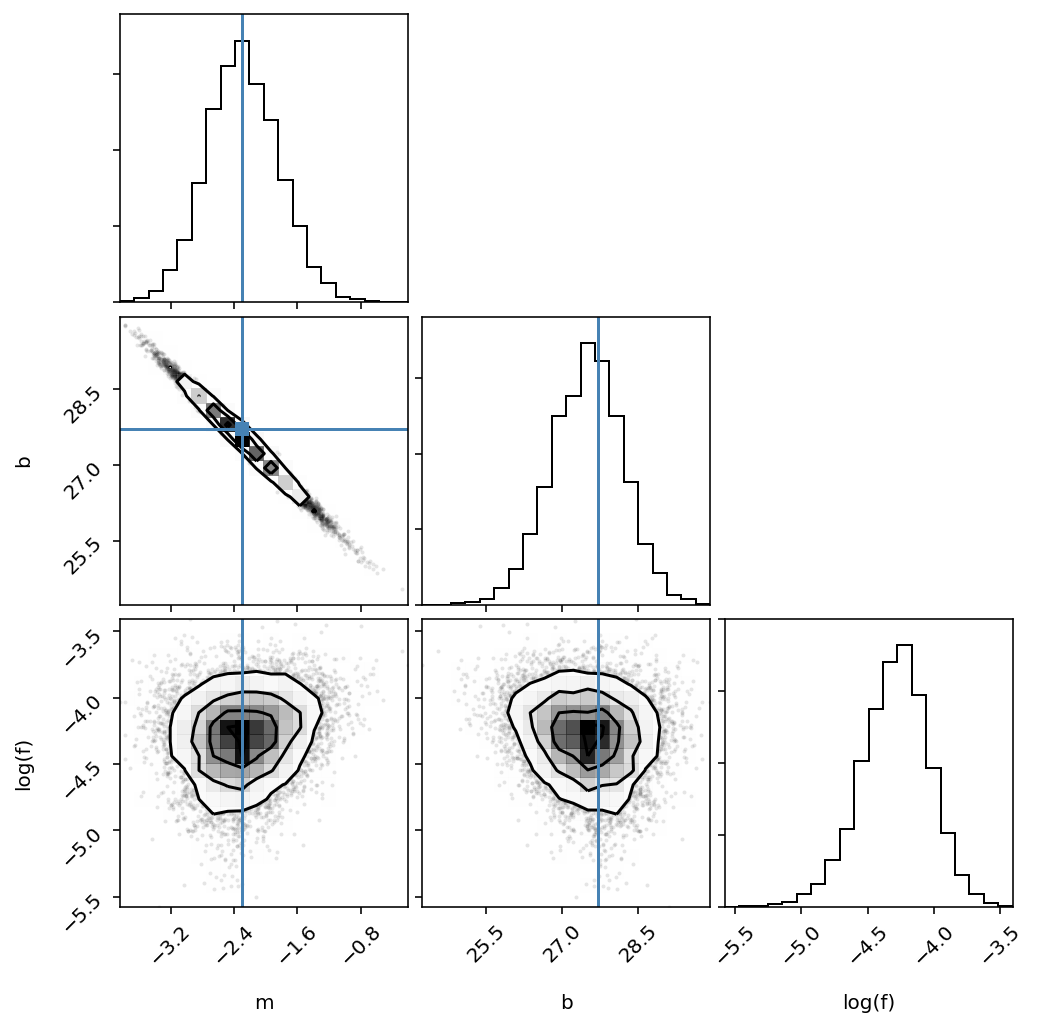

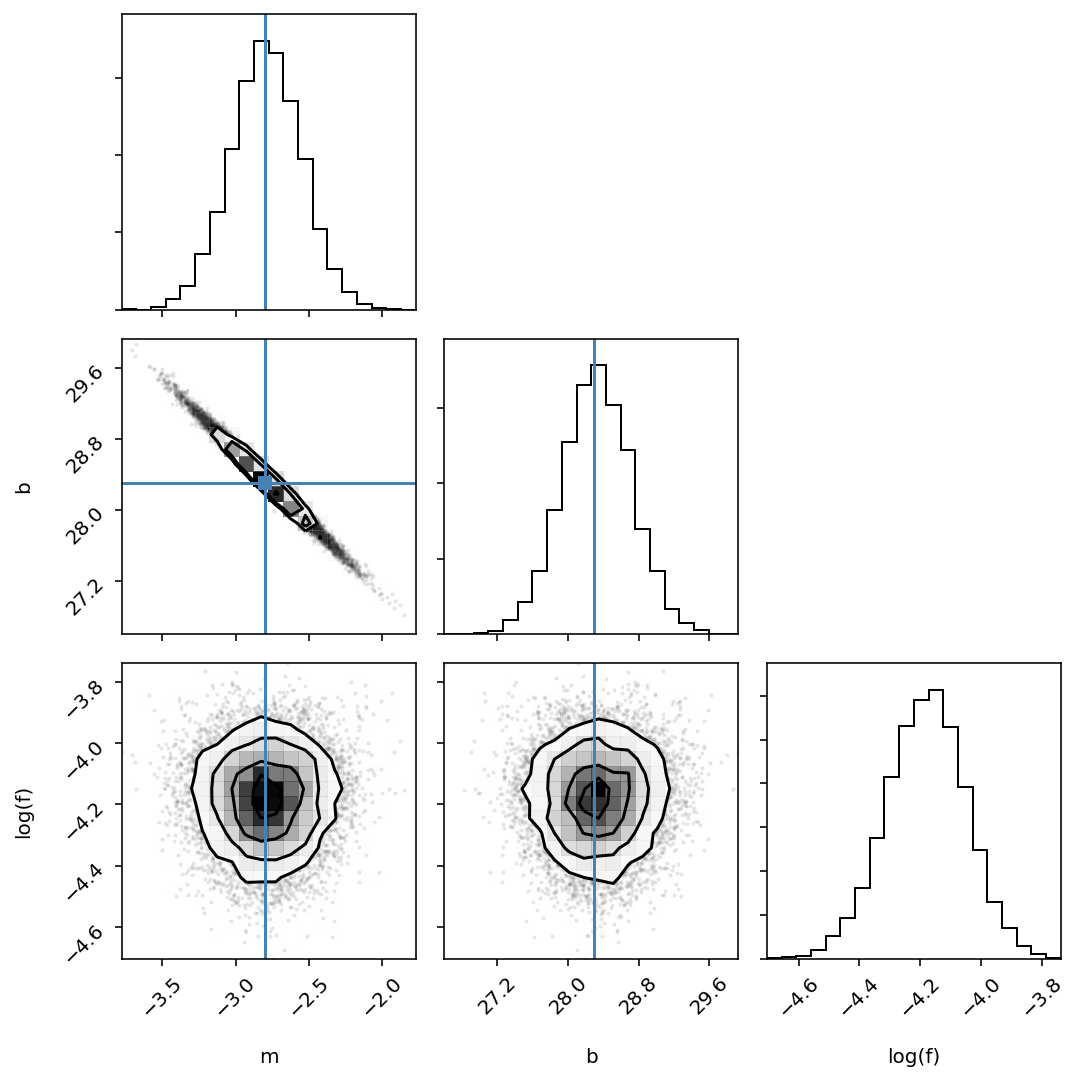

In [92]:
from scipy.optimize import minimize
import emcee
import corner
from IPython.display import display, Math

fig = plt.figure(figsize=(10, 10))
fig, axs = plt.subplots(3,3, figsize=(10, 10))
fig.subplots_adjust(hspace = .5, wspace=.01)
axs = axs.ravel()

mT = np.array((-2.1, -3.0, -3.0, -3.2, -2.5, -3.2, -3.0, -2.3, -2.8))
bT = np.array((27.9, 29.2, 29.0, 28.8, 27.5, 26.4, 27.9, 27.7, 28.3))
fT = np.array((0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05))

for i, ID in enumerate(hosts):
    ceph.select(ID)
    mobs = ceph.mobs
    logP = ceph.logP
    sigma_obs = ceph.sigma
    
    x = np.array(logP)
    y = np.array(mobs)
    yerr = np.array(sigma_obs)
    
    m_true = mT[i]
    b_true = bT[i]
    f_true = fT[i]
    
    np.random.seed(42)
    nll = lambda *args: -log_likelihood(*args)
    initial = np.array([m_true, b_true, np.log(f_true)]) + 0.1 * np.random.randn(3)
    soln = minimize(nll, initial, args=(x, y, yerr))
    m_ml, b_ml, log_f_ml = soln.x

    pos = soln.x + 1e-4 * np.random.randn(32, 3)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(x, y, yerr))
    sampler.run_mcmc(pos, 5000, progress=True)
    #tau = sampler.get_autocorr_time()
    #print("autocorrelation time is", tau)
    
    #discard the initial burn in steps, 
    #the autocorrelation was ~30, so thin by half
    #flatten the chain 
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True) 
    fig = corner.corner(flat_samples, labels=labels, truths=[m_true, b_true, np.log(f_true)])
    
    inds = np.random.randint(len(flat_samples), size=100)
    for ind in inds:
        sample = flat_samples[ind]
        axs[i].plot(x0, np.dot(np.vander(x0, 2), sample[:2]), "C1", alpha=0.1)
    axs[i].errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
    axs[i].plot(x0, m_true * x0 + b_true, "k", label="truth")
    axs[i].legend(fontsize=14)
    axs[i].set_xlim(0, 2.3)
    axs[i].invert_yaxis()
    axs[i].set_xlabel('log Period (days)')
    axs[i].set_ylabel('Magnitude')
    axs[i].set_title(ID)
    
    #GET THE MODEL FIT PARAMETERS WAHOOOO!!!
    print("ID:", ID)
    for i in range(ndim):
        mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
        q = np.diff(mcmc)
        txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
        txt = txt.format(mcmc[1], q[0], q[1], labels[i])
        display(Math(txt))
    
fig.tight_layout()

The model fits seem reasonable and the fit plots look quite similar compared to Reiss et al. (2011) Figure 7. He does his fits from the endpoints of the data, and not from the true y-intercept at a log Period of 0, however, so it's hard to do a strict 1-1 comparison.

You can ignore the "truth" line in these plots, because there is no actual truth (just my guess), but I was too lazy to rerun my entire notebook up to this point :p

Because there is a spread of fits to the y-intercept, I will take the 50th percentile number quoted above, and add the the uncertainty from the value at the 84th percentile. Thus, larger spreads will have a higher value, and thus the distance modulus will be accordingly characterized for each galaxy. Then the 50th percentile value from reference galaxy 4258 will be substracted to get $(\mu_{0,i} - \mu_{0,4258})$, and the resulting number is compared to Table 3 from Reiss et al (2011).

For example, for 3021, $\mu_{0,3021}=29.045 + 0.546 = 29.591$. 

For 4258, $\mu_{0,4258}=26.506$

And so, $(\mu_{0,3021} - \mu_{0,4258}) = 3.085.$

In [133]:
Reiss = np.array((3.276, 3.138, 2.835, 2.475, 2.396, 0.000, 1.567, 2.383, 2.461))
Solutie=np.array((2.289, 3.085, 2.796, 3.051, 1.373, 0.000, 1.592, 1.679, 2.214))

for i, ID in enumerate(hosts):
    print("ID", "   My solution", "           Reiss", "                  Difference (Me - Reiss)")
    print(ID, "(𝜇0−𝜇0,4258)=", Solutie[i], ", (𝜇0−𝜇0,4258)=", Reiss[i], " , ", Solutie[i]-Reiss[i], "\n")

ID    My solution            Reiss                   Difference (Me - Reiss)
1309 (𝜇0−𝜇0,4258)= 2.289 , (𝜇0−𝜇0,4258)= 3.276  ,  -0.9869999999999997 

ID    My solution            Reiss                   Difference (Me - Reiss)
3021 (𝜇0−𝜇0,4258)= 3.085 , (𝜇0−𝜇0,4258)= 3.138  ,  -0.052999999999999936 

ID    My solution            Reiss                   Difference (Me - Reiss)
3370 (𝜇0−𝜇0,4258)= 2.796 , (𝜇0−𝜇0,4258)= 2.835  ,  -0.039000000000000146 

ID    My solution            Reiss                   Difference (Me - Reiss)
3982 (𝜇0−𝜇0,4258)= 3.051 , (𝜇0−𝜇0,4258)= 2.475  ,  0.5760000000000001 

ID    My solution            Reiss                   Difference (Me - Reiss)
4038 (𝜇0−𝜇0,4258)= 1.373 , (𝜇0−𝜇0,4258)= 2.396  ,  -1.023 

ID    My solution            Reiss                   Difference (Me - Reiss)
4258 (𝜇0−𝜇0,4258)= 0.0 , (𝜇0−𝜇0,4258)= 0.0  ,  0.0 

ID    My solution            Reiss                   Difference (Me - Reiss)
4536 (𝜇0−𝜇0,4258)= 1.592 , (𝜇0−𝜇0,4258)= 1.567  ,  0.

This agreement is only ok at best. The general trend holds, however. The best agreements are galaxies 3021, 3370, 4536.

# Q4.

## Riess et al. do a *simultaneous* fit to the Cepheids and SNe data (Table 3 of their paper). 

## I'm slightly less cruel, so you can take your intercepts $\mu_{0,i} - \mu_{0, 4258}$ and the re-express equation 4 using a substitution of equation 3.

## Write that expression down.

The Reiss et al (2011) paper has equation 4 written as

$$ \log H_0 = \frac{(m_{v,4528}^0 - \mu_{0,4528} ) + 5a_v + 25}{5}. $$

However, in equation 3 we know:

$$ m_{v,i}^0 = (\mu_{0,i} - \mu_{0,4258}) + m_{v,4528}^0. $$

And so, if we rearrange their equation 3, we find

$$ m_{v,i}^0 - \mu_{0,i} = - \mu_{0,4258} + m_{v,4528}^0 = (m_{v,4528}^0 - \mu_{0,4258}). $$

Also, we remember that $ \mu_{0,i} = \mu_{0,4258} +b_i - zp_{W,4258} $.

Thus, our equation to solve for the Hubble constant is simply:

$$ \log H_0 = \frac{(m_{v,i}^0 - \mu_{0,4258} - \mu_{0,i}) + 5a_v + 25}{5} = \boxed{ \frac{(-\mu_{0,4258} - b_i + zp_{W,4258}) + (m_{v,i}^0 + 5a_v) + 25}{5}}. $$

In truth we want $H_0$, so

$$ \boxed{ H_0 = 10^{\frac{(-\mu_{0,4258} - b_i + zp_{W,4258}) + (m_{v,i}^0 + 5a_v) + 25}{5}}}. $$

# Q5

## Using the supernova data in Table 3 (enter it into whatever data structure you deem best) and the distance modulus to NGC 4258 from [Humphreys et al., 2013 ](https://ui.adsabs.harvard.edu/abs/2013ApJ...775...13H/abstract) and using the simple sample statistics you learned in Week 1, estimate the Hubble constant.

Humphreys et al. (2013) quotes $d_{0,4258}$ as 7.60 ± 0.17 ± 0.15 Mpc = 7600000 ± 170000 ± 150000 pc. However, we need $\mu_{0,4258}$. To do so, we use the distance modulus equation

$$ \mu = 5 \log(d/10 pc). $$

Using this equation, we find $\mu_{0,4258} = 29.4$.

In [3]:
m_plus_5av = np.array((16.768, 16.699, 16.545, 15.953, 15.901, 15.147, 16.040, 16.274)) #omit 4258 b/c no m0v,i + 5av value
b_i = np.array((28.076, 29.045, 28.997, 28.789, 27.516, 27.738, 27.509, 28.332)) #my y-intercepts for my fits
zpW4258 = 26.205 #from fit
mu04258 = 29.4 #from dist modulus eq

def H0(b_i, m_plus_5av):
    H_0 = 10**( ((-mu04258 - b_i + zpW4258) + (m_plus_5av) +25)/5 ) #10^blah b/c original eq has log H_0
    return H_0

myH0 = np.mean(H0(b_i, m_plus_5av)) #take mean to account for all galaxies
H0err = np.std(H0(b_i, m_plus_5av))
print("My mean H_0 value is...", myH0, "±", H0err, "km/s/Mpc")

My mean H_0 value is... 90.5765120199921 ± 22.18370681101049 km/s/Mpc


In [5]:
txt = "H_0 = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
txt = txt.format(myH0, H0err, H0err)
display(Math(txt))

<IPython.core.display.Math object>

I guess in the great debate between Gérard de Vaucouleurs and Allan Sandage, I side with de Vaucouleurs, though my error is so big the Hubble tension is nearly encapsulated in my answer :(

This is higher from the quoted Riess value because my y-intercepts for "b" must be overestimated (by which I mean my magnitudes are too high/ my y-intercepts are too low) compared to the fits as in Reiss et al (2011). My guess as to why is that my fits are done with the $logP$ range starting at 0 and ending at 2.3 days, and not at the endpoints for each dataset (that is, like 0.5 to 2.0 days as in the plot for 4258 in Figure 7 of Reiss). So they fit and then extrapolated to the y-intercept, whereas mine incorporated this in the fit (though I'm not totally sure if this *actually* makes a difference). Or maybe because he did his fits with 1 + N_gal params, while I had a 3 fit.